# Introduction

## Defending in Transition

### Prompt
The coaching staff have identified 3 games where we have performed very well, OK and very poorly in defensive transition (attack to defense). They are interested in the following questions:

- What has happened when the ball has been lost?
- How well have we performed stopping the opponent progressing the ball after turnover?
- How compact have we been as a team in transition?

They are also open to your feedback on: 

- What are the factors that might impact our performance in defensive transition?
- What would you like to analyse next?

### Instructions

Please use the provided data to build a data-driven narrative addressing these questions that you could deliver to coaching staff in a 10-15 minute presentation. State any assumptions you've made, define any terms if necessary and include all supporting code and data visualisations.

Please note that the exercise is deliberately open-ended; there is no single correct answer or "trick". We want to see how you can apply your coding and data science skills to extract and present insights from the provided data, and how you can apply your football knowledge to translate those insights into a compelling, succinct narrative for coaching staff. We do *not* intend this to be an exercise in boiling the ocean as we appreciate you may have limited time to devote to football analytics job applications, so you can consider the 10-15 minute time limit on the presentation as a helpful scoping prompt. 

### Data and Tools
- 3-game sample of event and tracking data, and supporting metadata
    - [Events](./data/events.csv)
    - [Event type name to ID mappings](./data/eventTypes.tsv)
    - [Phase of play by event](./data/phaseOfPlay.csv)
    - [Team abbreviation to ID mappings](./data/teams.tsv)
    - [Optical tracking data](./data/tracking.csv.gz)
- A simple video player API to retrieve video clips for a given game and timestamp, and optionally add custom captions
- Dockerfile containing a full data science stack for R / Python / Spark and typical packages

**You do not have to use Docker or even this Jupyter notebook; they are optional and provided for your convenience. Our only requirement is that you submit to us your code and supporting materials in a format that is easy to read, execute and reproduce. Jupyter notebooks just happen to be very convenient to that end!**

#### Tips for Getting Started
This event and tracking data is a simplified version of what we use internally at Arsenal. While there are some minor data wrangling steps left deliberately to you to sort out, you should find working with it to be straightforward. Nevertheless, here are a few tips to set you off on the right foot:
- Pitch coordinates are relative to the broadcast video main camera view and don't take into account teams switching sides, so you will find the `attackingDirectionMultiplier` column helpful
- Event location coordinates (`positionX`,`positionY`) are mapped to an idealized pitch and don't take into account differing pitch sizes
- Tracking location coordinates (`fieldCoordinateX`,`fieldCoordinateY`) are measured in meters with (0,0) at the center of the pitch
- The ball location in the tracking data is set to (0,0,-10) when the ball is out of bounds. Please give credit to Second Spectrum for this design decision.
- Working with the tracking data can be very memory-intensive. Here are some general tips if you haven't worked with tracking data before:
  - If running in a Docker container, make sure Docker has at least 4GB of memory allocated (assuming no other containers are running)
  - Consider using a library like `dask` to read the CSV in blocks (you will need to unzip it first) and filter it down to just the rows / columns you need
  - If this is all uncharted territory for you and you are hitting memory issues (crashing Jupyter kernel), consider starting with just the event data
  
### Output
This notebook is intended as a sample / template and you are welcome to either clone it, extend and use it directly, or create and provide your own notebook (e.g. if you are more comfortable in R). However, please ensure that whatever you provide back to us is: 
- Trivial for us to both read and execute
- Contains _all_ of your supporting code and visualisations

You may also choose to send supporting slides for your presentation (PDF, Keynote or PPTX are fine), but they are not required.

Please do not send _only_ spreadsheets, Tableau workbooks, or similar. While such tools certainly have a role to play in football analytics, we expect to see code in a modern programming language well-suited to data analysis and machine learning (preferably Python or R).

The schema of the data should be fairly self-explanatory, but if you have any questions or concerns, you are more than welcome to email us: 
- [Tolly](mailto:pcoburn@arsenal.co.uk)
- [Chris](mailto:cdove@arsenal.co.uk)


### Setup

In [1]:
import pandas as pd
import numpy as np
import requests
import dask.dataframe as dd

from IPython.display import display_html, display, HTML
from typing import Union

pd.options.display.max_columns = 999
pd.options.display.max_rows = 999
pd.options.mode.chained_assignment = None

In [2]:
events = pd.read_csv('./data/events.csv')
phases = pd.read_csv('./data/phaseOfPlay.csv')
eventTypes = pd.read_csv('./data/eventTypes.tsv', sep='\t')
teams = pd.read_csv('./data/teams.tsv', sep='\t')
players = pd.read_csv('./data/players.tsv', sep='\t')
eventTypesDetailed = pd.read_csv('./data/eventTypesDetailed.tsv', sep='\t')

In [3]:
# # WARNING: This is ~1GB uncompressed
tracking = pd.read_csv('./data/tracking.csv.gz', 
                       compression='gzip', 
                       usecols=['gameid','currentperiod','sinceperiodstart','playerid','fieldcoordinatex','fieldcoordinatey','ballcoordinatex','ballcoordinatey','attackingDirectionMultiplier'] 
                  )

tracking = tracking.rename(
    columns={'gameid':'gameId',
             'playerid':'playerId',
             'currentperiod':'currentPeriod',
             'sinceperiodstart':'sincePeriodStart'})


## Video Player
You can use this crude video player to see WyScout video corresponding to any timestamp in the provided data. 

You can also use the optional caption capability to pass in arbitrary sets of timestamped captions in the format:
`https://v13ynl3l58.execute-api.us-east-1.amazonaws.com/temp/vtt?game_id={game_id}&time={time}&pre={pre}&post={post}&w=600&h=450&cues={caption_str}`

where `{caption_str}` takes the form `{time_s_start},{time_s_stop},{text}!`

**NB: The video player API expects time offsets in _seconds_ whereas all event and tracking data time offsets are in _milliseconds_**

Below you will find some examples of using the video player with and without captions.

In [4]:
sample_captions=events.assign(begin=lambda x: (x['sinceVideoStart'] - 250) / 1000.0,
                              end=lambda x: (x['sinceVideoStart'] + 750) / 1000.0,
                              text=lambda x: "EventID: " + x['eventId'].astype('str'))[['gameId','begin','end','text']]

In [5]:
def get_video(game_id: int, eventSinceVideoStart: int, pre:int=0, post:int=5, player=True, captions=None) -> Union[None,str]:
    time = eventSinceVideoStart / 1000.0
    if captions is not None:
        begin = time - pre
        end = time + post
        active_caption = captions[(captions.gameId==game_id) & (captions.begin>=begin) & (captions.end<=end)].dropna()
        caption_str = ''
        for index, row in active_caption.iterrows():
            caption_str = caption_str + f"{row['begin']},{row['end']},{row['text']}!"
        url = f"https://v13ynl3l58.execute-api.us-east-1.amazonaws.com/temp/vtt?game_id={game_id}&time={time}&pre={pre}&post={post}&w=600&h=450&cues={caption_str}"
    else:
        url = f'https://v13ynl3l58.execute-api.us-east-1.amazonaws.com/temp/video?game_id={game_id}&time={time}&pre={pre}&post={post}'
    
    if player:
        resp = requests.get(url)
        display(HTML(resp.text))
    else:
        return url

In [6]:
#get_video(77512, 5097000, pre=5, post=10, player=True)

In [7]:
#get_video(77669,127961,pre=0,post=10, player=False, captions=sample_captions)

### Best of luck and have fun!

# Report

In [8]:
import seaborn as sns
from mplsoccer import Pitch
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

## Where are we losing the ball

Before we look into what happens after we lose the ball, first I want to give you a quick overview of where our opponents are starting their attacks when we lose possession:

In [9]:
# Adding extra information  
events_selected = events.merge(
    eventTypes, how='left', on='eventTypeId'
).merge(
    teams, how='left', on='teamId'
).merge(
    phases, how='left', on='eventId'
).merge(
    players, how='left', on='playerId'
)[['gameId','homeTeamId','currentPeriod', 'sincePeriodStart', 'eventId', 'eventTypeName', 'teamName',
   'homeTeamPhaseName','awayTeamPhaseName', 'playerName', 'expectedGoalValue', 'expectedGoalValueDelta',
   'currPossessionsCnt','possessionTeamIdUninterrupted', 'teamScore', 'oppositionScore', 'positionX',
   'positionY','attackingDirectionMultiplierX', 'attackingDirectionMultiplierY']]

In [10]:
def get_game_state(df):
    
    """This function works out the game state"""
    
    if not np.isnan(df['teamScore']):
        if df['teamScore'] > df['oppositionScore']:
            df['gameState'] = 1
        elif df['teamScore'] == df['oppositionScore']:
            df['gameState'] = 0
        elif df['teamScore'] < df['oppositionScore']:
            df['gameState'] = -1
            
        if df['homeTeamId'] != 234:
            df['gameState'] = df['gameState'] * -1
            
    return df

def get_pitch_zone(df):
    
    """This function calculates which zone on the pitch a given event happens in.
    It calculates this both relative to the team in possession (df['zone']) and 
    relative to Arsenal (df['arsenalZone']).
    
    The pitch is split up into 3 horizontal 3rds (Right, Central, Left) and into
    3 vertical 3rds (Defensive, Middle, Attacking), to give 9 equal zones."""
    
    if np.isnan(df['attackingDirectionMultiplierX']):
        df['zone'] = None
        df['arsenalZone'] = None
    
    elif df['positionX'] * df['attackingDirectionMultiplierX'] < (-58 + 116/3):
        if df['positionY'] * df['attackingDirectionMultiplierY'] < (-44 + 88/3):
            df['zone'] = 1
        elif df['positionY'] * df['attackingDirectionMultiplierY'] < (44 - 88/3):
            df['zone'] = 2
        else:
            df['zone'] = 3

    elif df['positionX'] * df['attackingDirectionMultiplierX'] < (58 - 116/3):
        if df['positionY'] * df['attackingDirectionMultiplierY'] < (-44 + 88/3):
            df['zone'] = 4
        elif df['positionY'] * df['attackingDirectionMultiplierY'] < (44 - 88/3):
            df['zone'] = 5
        else:
            df['zone'] = 6

    else:
        if df['positionY'] * df['attackingDirectionMultiplierY'] < (-44 + 88/3):
            df['zone'] = 7
        elif df['positionY'] * df['attackingDirectionMultiplierY'] < (44 - 88/3):
            df['zone'] = 8
        else:
            df['zone'] = 9
            
    if df['teamName'] != 'ARSL' and df['zone']:
        df['arsenalZone'] = 10 - df['zone']
    else:
        df['arsenalZone'] = df['zone']
            
    return df

def calculate_success(df):
    
    """This function calculates whether certain (usually passing) events were successful or not."""
    
    if df['eventTypeName'] in ['Pass Ground', 'Pass Air', 'Pass Head', 'Cross', 'Throw in', 'Head Clearance',
                              'Clearance', 'Goalie Throw', 'Goalie Punt', 'Goalie Punch']:
        if df['nextTeamName'] == df['teamName']:
            df['success'] = 1
        else:
            df['success'] = 0
            
    else:
        df['success'] = np.nan
        
    return df

In [11]:
# Adding game state, zone and pass columns  
events_selected = events_selected.apply(get_game_state, axis=1)

events_selected = events_selected.apply(get_pitch_zone, axis=1)

events_selected['pass'] = events_selected['eventTypeName'].apply(lambda x: 1 if 'Pass' in x else 0)

events_selected['nextTeamName'] = events_selected.groupby(['gameId', 'currentPeriod'])['teamName'].shift(-1)
events_selected = events_selected.apply(calculate_success, axis=1)

For this, we're only going to look at opponents' sequences that begin in open play, rather than from a free-kick/throw in etc., since these are the ones where we need to transition effectively from attack to defence. When the ball goes out of play, we (generally) have a bit more time to reset into our defensive shape.

In [12]:
# Identifying where open play starts and ends 
out_of_play_events = ['Out of bounds', 'Throw in', 'Sub In', 'Free Kick', 'Restricted View', 'Goal Kick', 
                      'Foul', 'Corner', 'Tackle Lost (Foul)', 'Sub Out', 'Kick Off', 'Offside', 'Yellow Card',
                      'Offsensive side 1st half', 'First Half', 'Offensive side second half', 'Second Half']

events_selected['inPlay'] = events_selected['eventTypeName'].apply(
    lambda x: 1 if not x in out_of_play_events else 0)


events_selected['inPlayPrevious'] = events_selected.groupby(
    ['gameId', 'currentPeriod']
)['inPlay'].shift(
    fill_value = 0
)

events_selected['inPlayDiff'] = events_selected['inPlay'] - events_selected['inPlayPrevious']
events_selected['inPlayStart'] = events_selected['inPlayDiff'].apply(lambda x: 1 if x == 1 else 0)
events_selected['inPlayEnd'] = events_selected['inPlayDiff'].apply(lambda x: 1 if x == -1 else 0).shift(-1)

In [13]:
# Finding the starts of sequences 
opp_sequences = events_selected[events_selected['possessionTeamIdUninterrupted'].isin([235,771,1226])]

opp_sequences_starts = opp_sequences.groupby(
    ['gameId', 'currPossessionsCnt'],
    as_index=False
).first()

opp_sequences_starts = opp_sequences_starts[opp_sequences_starts['inPlayStart'] == 0]

opp_sequences_counts = opp_sequences_starts.groupby(
    ['gameId', 'arsenalZone'], as_index=False
)[['currPossessionsCnt']].count()

opp_sequences_counts = opp_sequences_counts.pivot(
    index = 'gameId', columns='arsenalZone', values='currPossessionsCnt'
).fillna(
    0
)

In [14]:
# Plotting variables 
bfc_hex = "#e30613"
wfc_hex = "#FBEE23"
lfc_hex = "#C8102E"
afc_hex = "#EF0107"

opponent_names = {0:[77214, 'Brentford', bfc_hex],
                  1:[77512, 'Watford', wfc_hex],
                  2:[77669,'Liverpool', lfc_hex]}

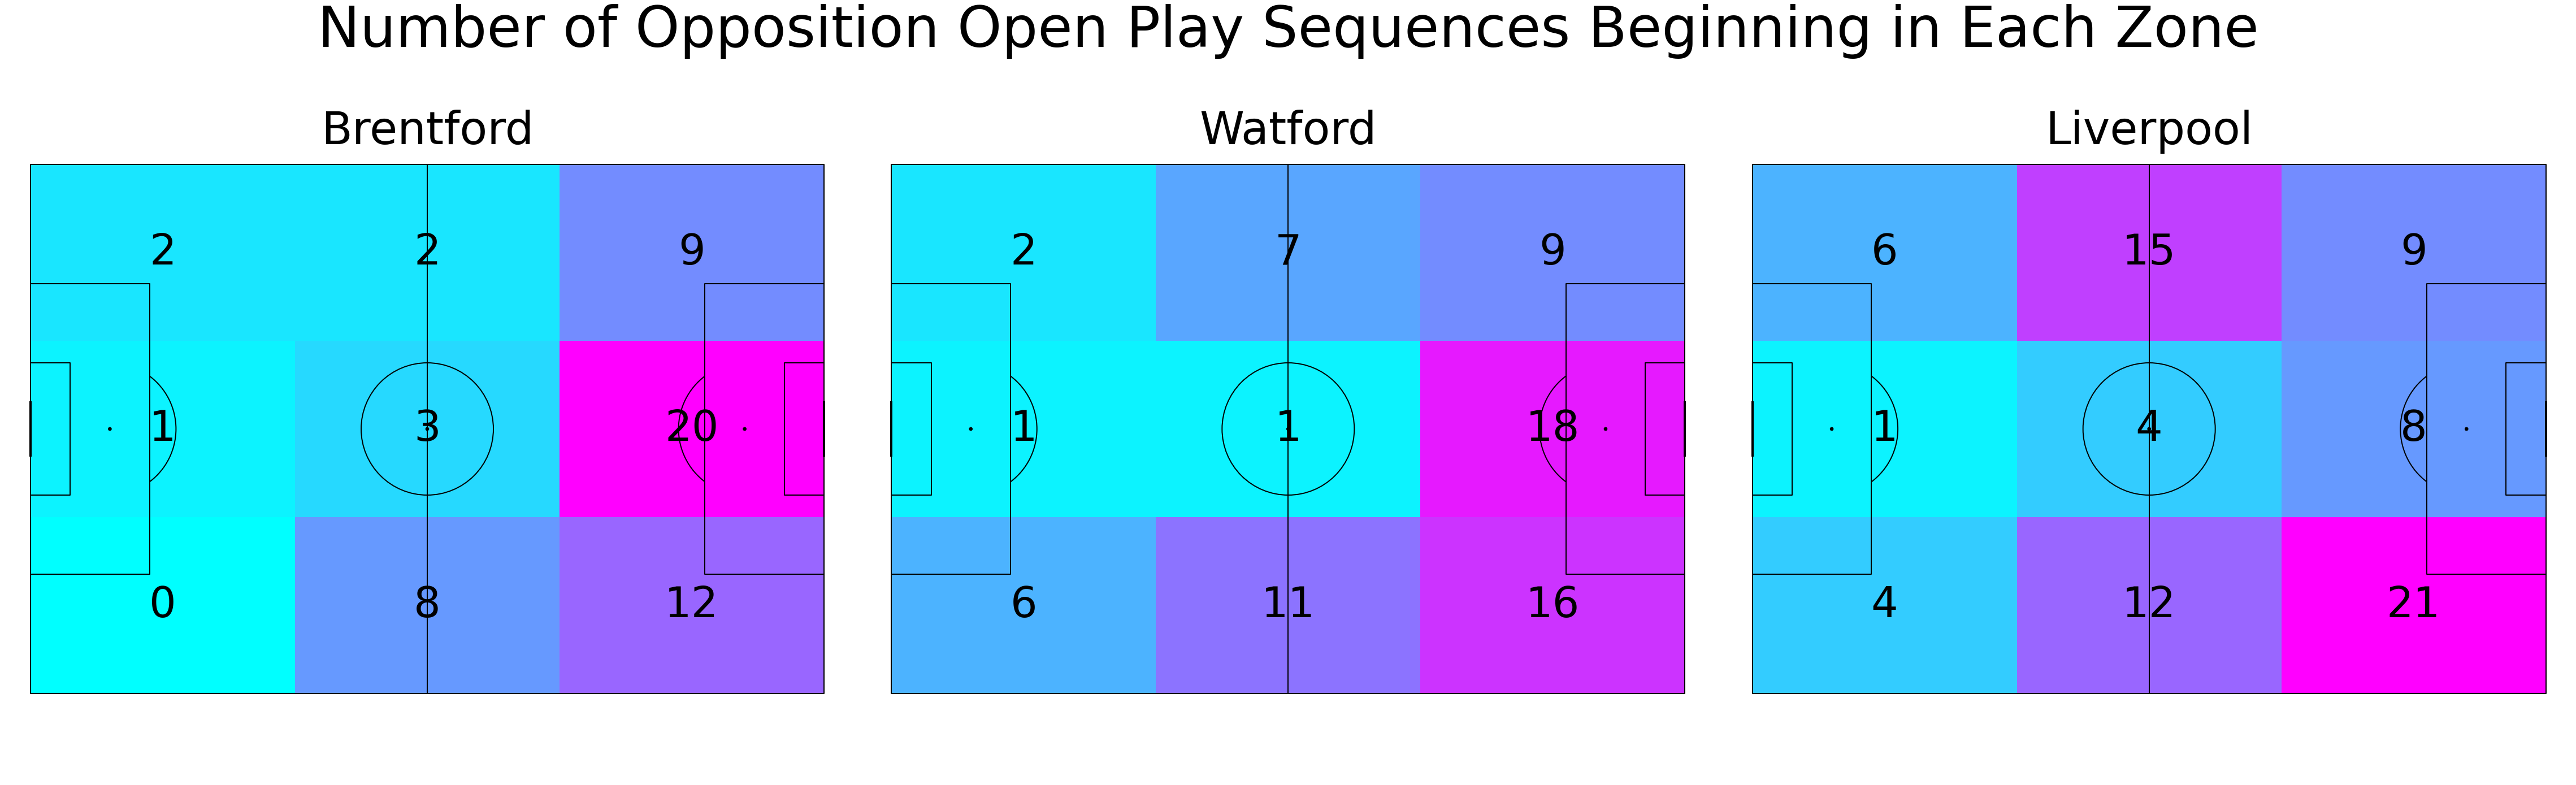

In [15]:
# Start of sequence heatmaps 
pitch = Pitch(line_zorder=2, line_color='black')

fig, axs = pitch.grid(nrows=1, ncols=3, figheight=20,axis=False)

fig.suptitle("Number of Opposition Open Play Sequences Beginning in Each Zone", size=100)
fig.set_facecolor('white')

bin_statistic = pitch.bin_statistic([0], [0], statistic='count', bins=(3, 3))


for i in range(len(opponent_names)):

    axs['pitch'][i].text(60, -5, opponent_names[i][1],
                ha='center', va='center', fontsize=80)
    bin_statistic['statistic'] = np.flip(np.array(opp_sequences_counts[i:i+1]).reshape(3,3).T, axis=0)
    heatmap = pitch.heatmap(bin_statistic, ax=axs['pitch'][i], cmap='cool', vmin=0, vmax=20)
    annotate = pitch.label_heatmap(bin_statistic, color='black',
                               fontsize=75, ax=axs['pitch'][i],
                               ha='center', va='center', str_format='{0:.0f}')

From these pitch maps, we can see that in general we tended to give the ball away more in forward areas and more in wide areas. Given that these are the less dangerous areas of the pitch to give the ball away, this is a good thing.

Brentford was the best of the three performances in this regard, where we only allowed the opposition to start open play sequences in our defensive third three times. We were worse against Watford, where we gave them the ball 9 times in our defensive third, including 6 on our right hand side, and 11 times against Liverpool. Against Liverpool, there were more turnovers overall, and considerably more in the middle third.

This is supported by the Expected Goals values at the start of these sequences, which show that we gave Liverpool the most opportunities and Brentford the least based on where we lost the ball in open play:

In [16]:
# Calculate starting xG 
sequence_start_xG = opp_sequences_starts.groupby(
    'gameId', as_index=False
).agg(
    {'expectedGoalValue':['sum','mean']}
)

sequence_start_xG.columns=['gameId', 'total_xG', 'mean_xG']

sequence_start_xG['opponent'] = pd.Series(['Brentford', 'Watford', 'Liverpool'])

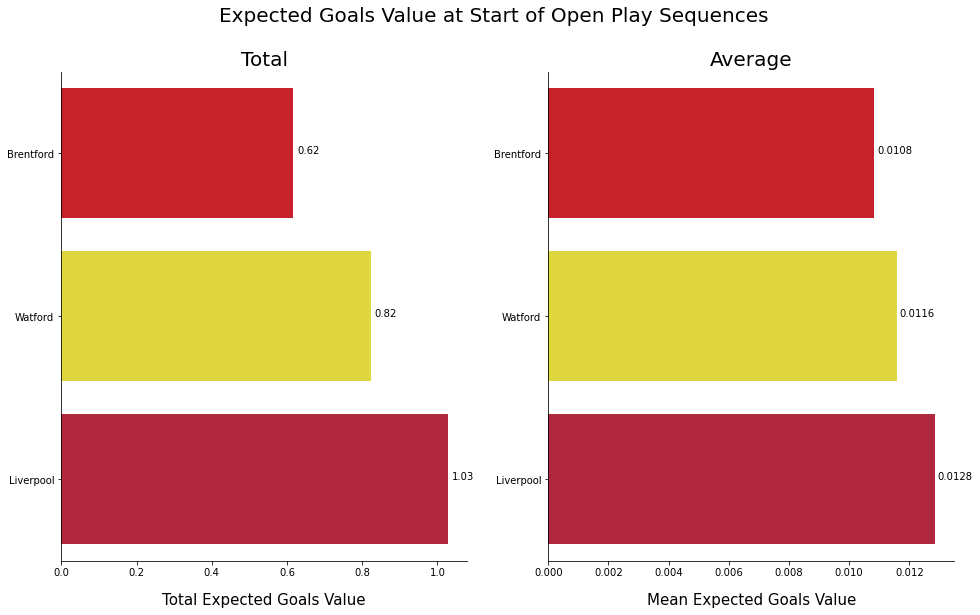

In [17]:
# Starting xG plot 
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 9))

sns.barplot(y = sequence_start_xG['opponent'], x = sequence_start_xG['total_xG'],
            ax=axs[0], palette=[bfc_hex, wfc_hex, lfc_hex])
axs[0].set_ylabel('')
axs[0].set_xlabel('Total Expected Goals Value', size=15, labelpad = 15)
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)

for i in range(len(sequence_start_xG['opponent'])):
    axs[0].text(sequence_start_xG['total_xG'][i] + 0.01,i,round(sequence_start_xG['total_xG'][i],2))

sns.barplot(y = sequence_start_xG['opponent'], x = sequence_start_xG['mean_xG'],
            ax=axs[1],palette=[bfc_hex, wfc_hex, lfc_hex])
axs[1].set_ylabel('')
axs[1].set_xlabel('Mean Expected Goals Value', size=15, labelpad = 15)
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)

for i in range(len(sequence_start_xG['opponent'])):
    axs[1].text(sequence_start_xG['mean_xG'][i] + 0.0001,i,round(sequence_start_xG['mean_xG'][i],4))

fig.suptitle("Expected Goals Value at Start of Open Play Sequences", size =20)
axs[0].set_title("Total", size=20)
axs[1].set_title("Average", size=20);

## What has happened when the ball has been lost?

In [18]:
def arsenal_defensive_transition(df):
    
    """This function calculates whether Arsenal are in Defensive Transition,
    according to the label from AFC's Phase of Play model."""
    
    if df['homeTeamId'] == 234:
        if df['homeTeamPhaseName'] == 'TransitionAttackToDefence':
            df['defensiveTransition'] = 1
        else:
            df['defensiveTransition'] = 0
    else:
        if df['awayTeamPhaseName'] == 'TransitionAttackToDefence':
            df['defensiveTransition'] = 1
        else:
            df['defensiveTransition'] = 0      
    
    return df

def get_team_phases(df):
    
    """This function works out which phase of play Arsenal + their opposition are in
    based on whether they are the home or away team."""
    
    if df['homeTeamId'] == 234:
        df['oppositionPhase'] = df['awayTeamPhaseName']
        df['arsenalPhase'] = df['homeTeamPhaseName']
    else:
        df['oppositionPhase'] = df['homeTeamPhaseName']
        df['arsenalPhase'] = df['awayTeamPhaseName']       
    return df

In [19]:
# Adding new columns 
events_selected = events_selected.apply(arsenal_defensive_transition, axis=1)

events_selected['endPositionX'] = events_selected['positionX'].shift(-1)
events_selected['endPositionY'] = events_selected['positionY'].shift(-1)

events_selected = events_selected.apply(get_team_phases, axis=1)

In [20]:
# Finding Arsenal's next phase 
next_phase = events_selected[~events_selected['arsenalPhase'].isnull()]

next_phase['nextArsenalPhase'] = next_phase.groupby(
    ['gameId', 'currentPeriod']
)['arsenalPhase'].shift(-1)

events_selected = events_selected.merge(
    next_phase[['eventId', 'nextArsenalPhase']],
    how='left', on='eventId')

### Opposition Phase During Our Defensive Transition

First, here's what phase the opposition are in while we are in Defensive Transition:

In [21]:
# Finding opposition phase during transition 
defensive_transition_events = events_selected[events_selected['defensiveTransition'] == 1]

opposition_phases = defensive_transition_events.groupby(
    ['gameId', 'oppositionPhase'], as_index=False
)['eventId'].count()

# Adding these rows in for completeness in the plot
opposition_phases = pd.concat(
    [opposition_phases,
     pd.DataFrame({'gameId':[77214, 77669],
              'oppositionPhase':['AttackingProgressionFinalThird', 'AttackingProgressionFinalThird'],
              'eventId':[0,0]})]
).sort_values(['gameId', 'oppositionPhase'])

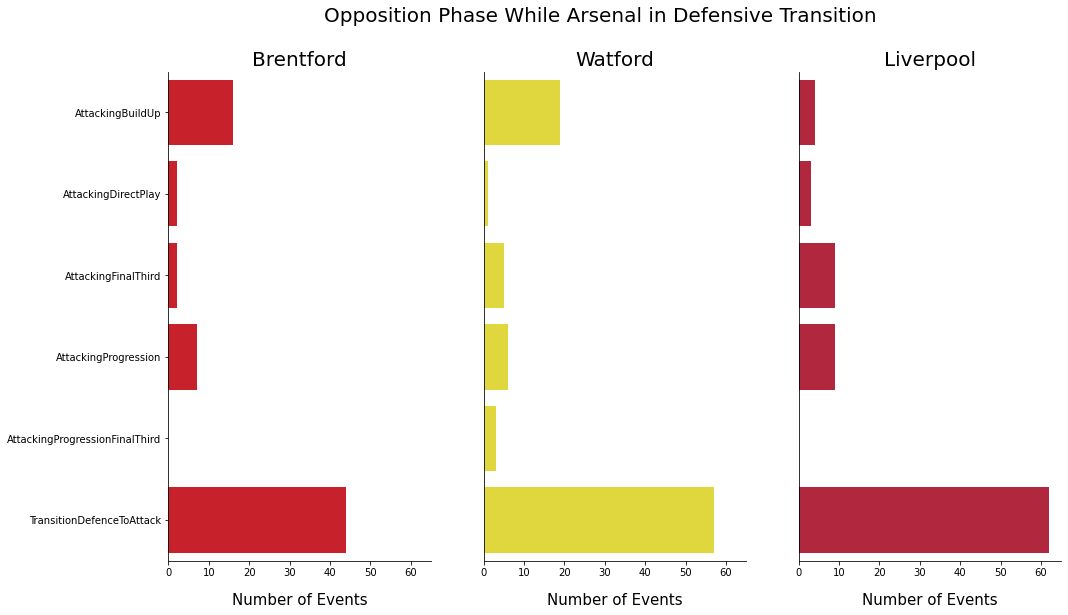

In [22]:
# Opposition phase plot 
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 9))

for i in range(len(opponent_names)):
    
    sns.barplot(y = opposition_phases[opposition_phases['gameId'] == opponent_names[i][0]]['oppositionPhase'],
            x = opposition_phases[opposition_phases['gameId'] == opponent_names[i][0]]['eventId'],
            ax=axs[i], palette=[opponent_names[i][2]])
    axs[i].set_ylabel('')
    axs[i].set_xlabel('Number of Events', size=15, labelpad = 15)
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].set_title(opponent_names[i][1], size=20)
    axs[i].set_xlim(0, 65)

axs[1].set_yticks([])
axs[2].set_yticks([])

fig.suptitle("Opposition Phase While Arsenal in Defensive Transition", size =20);

For the majority of the time during defensive transitions, as you'd expect, the opposition were also in transition from defence to attack. However, there were some key differences between the three matches:

* Against Brentford, there were more instances where we successfully restricted them to *AttackingBuildUp*, which is less dangerous given this phase mostly consists of horizontal passes and is mostly in our attacking third
* Against Watford and Liverpool, there were more occasions when they were in *AttackingProgressionFinalThird* or *AttackingFinalThird*, which is clearly a more dangerous situation
* Additionally, against Liverpool, *AttackingBuildUp* was rare

This fits with what we saw earlier about where we tended to lose the ball in these games - most dangerous against Liverpool, and least dangerous against Brentford.

### Arsenal Next Phase After Transition

In [23]:
# Finding Arsenal's next phase 
next_arsenal_phases = defensive_transition_events.groupby(
    ['gameId', 'nextArsenalPhase'], as_index=False
)['eventId'].count()

next_arsenal_phases = next_arsenal_phases[next_arsenal_phases['nextArsenalPhase'] != 'TransitionAttackToDefence']

# Adding these rows for completeness on the plot
next_arsenal_phases = pd.concat(
    [next_arsenal_phases,
     pd.DataFrame({'gameId':[77214, 77214, 77669, 77669, 77669],
              'nextArsenalPhase':['AttackingProgressionFinalThird', 'AttackingDirectPlay',
                                 'AttackingProgressionFinalThird', 'AttackingFinalThird', 'DefendingDirectPlay'],
              'eventId':[0,0,0,0,0]})]
).sort_values(['gameId', 'nextArsenalPhase'])

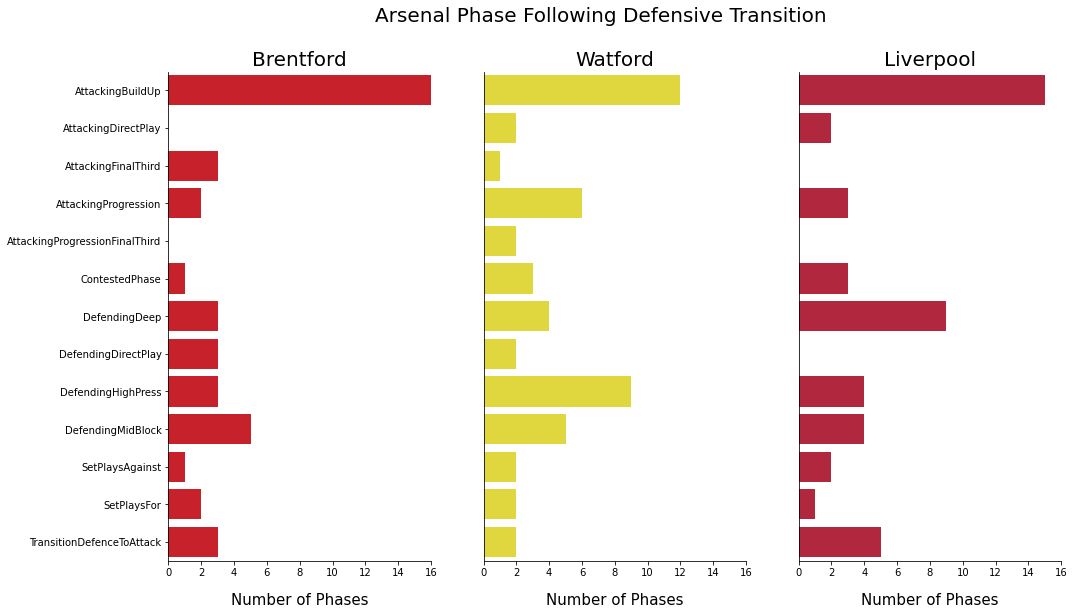

In [24]:
# Arsenal next phase plot 
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 9))

for i in range(len(opponent_names)):
    
    sns.barplot(y = next_arsenal_phases[next_arsenal_phases['gameId'] == opponent_names[i][0]]['nextArsenalPhase'],
            x = next_arsenal_phases[next_arsenal_phases['gameId'] == opponent_names[i][0]]['eventId'],
            ax=axs[i], palette=[opponent_names[i][2]])
    axs[i].set_ylabel('')
    axs[i].set_xlabel('Number of Phases',size=15, labelpad = 15)
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].set_title(opponent_names[i][1], size=20)
    axs[i].set_xlim(0, 16)
    
axs[1].set_yticks([])
axs[2].set_yticks([])

fig.suptitle("Arsenal Phase Following Defensive Transition", size =20);

From this chart, there are a few features that stand out from these games:
* **Brentford**: 26/42 (62%) of these defensive transitions ended with us in an attacking phase. This suggests that we were largely successful in winning the ball back in these transitions
* **Watford**: A lower proportion resulted in us regaining possession (27/52 = 52%), but there were more examples of defensive transitions leading to dangerous progressive attacks. A good example of this is below, where immediate counter-pressing from Partey & Odegaard on Cucho Hernandez resulted in a dangerous cross from Pepe
* **Watford**: Where we failed to win the ball back, we managed to transition often into *DefendingHighPress* and *DefendingMidBlock*, keeping the opposition futher away from goal
* **Liverpool**: We generated few attacking opportunities through defensive transition (0 leading to *AttackingFinalThird* or *AttackingProgressionFinalThird*), and we tended to end up retreating to *DefendingDeep* when we failed to win the ball back immediately. This is also presumably related to the fact that we generally lost the ball deeper against Liverpool than in the other two games

In [25]:
# Partey + Odegaard Counter-Pressing Video 
get_video(77512, 5097000, pre=5, post=10, player=True)

time.sleep(25)
clear_output()

### Opposition Passing Patterns

In [26]:
# Finding passes while Arsenal in defensive transition 
passes = defensive_transition_events.copy()

passes = passes[passes['eventTypeName'].str.contains('Pass')]

passes['positionX'] = 120 - (passes['positionX'] * passes['attackingDirectionMultiplierX'] + 60)
# Applying this conversion to fit the plot
passes['positionY'] = 80 - (passes['positionY'] * passes['attackingDirectionMultiplierY'] + 45) * (80/90)
passes['endPositionX'] = 120 - (passes['endPositionX'] * passes['attackingDirectionMultiplierX'] + 60)
passes['endPositionY'] = 80 - (passes['endPositionY'] * passes['attackingDirectionMultiplierY'] + 45) * (80/90)

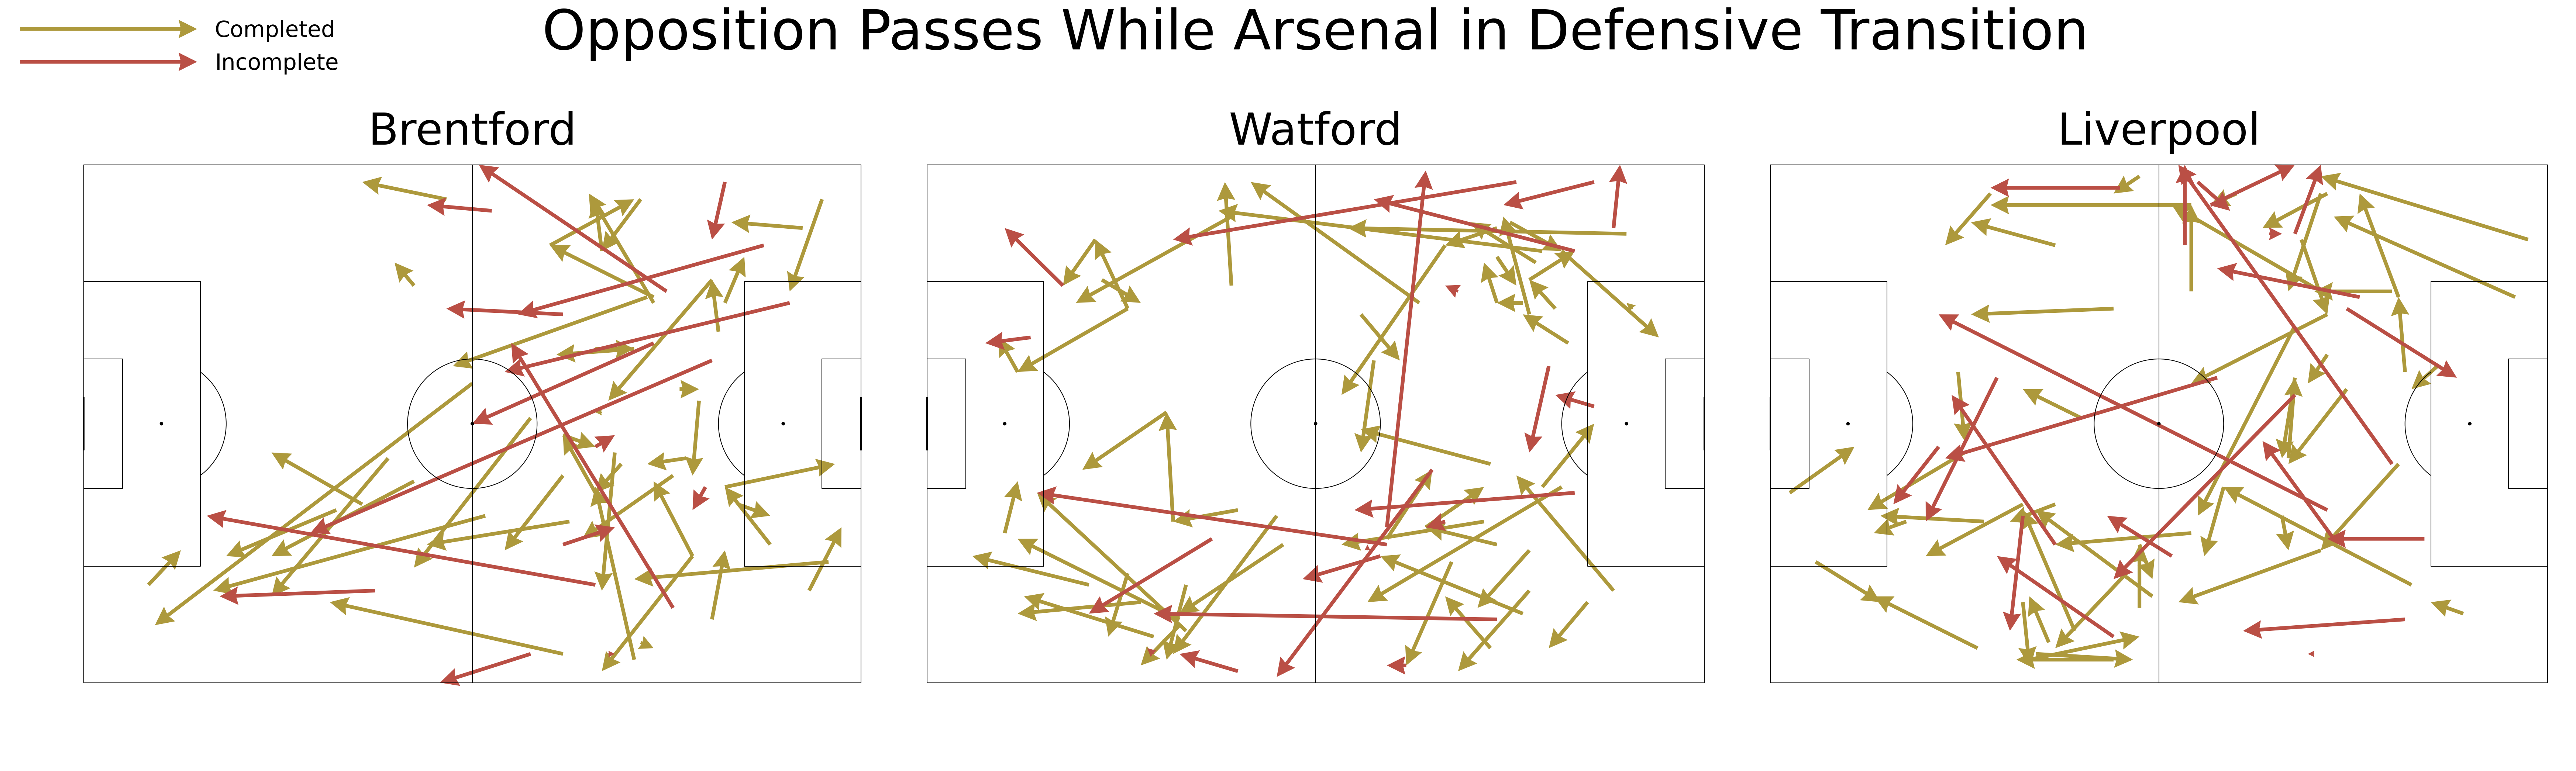

In [27]:
# Pass maps 
pitch = Pitch(line_zorder=2, line_color='black')

fig, axs = pitch.grid(nrows=1, ncols=3, figheight=30,axis=False)

for i in range(len(opponent_names)):
    
    match_passes = passes[passes['gameId'] == opponent_names[i][0]]
    
    completed_passes = match_passes[match_passes['success'] == 1]
    incomplete_passes = match_passes[match_passes['success'] == 0]
    
    if i == 0:
        label_complete = 'Completed'
        label_incomplete = 'Incomplete'
    else:
        label_complete = ''
        label_incomplete = ''        

    pitch.arrows(completed_passes['positionX'], completed_passes['positionY'],
                 completed_passes['endPositionX'], completed_passes['endPositionY'], width=10,
                 headwidth=5, headlength=5,
                 color='#ad993c', ax=axs['pitch'][i], label=label_complete)

    pitch.arrows(incomplete_passes['positionX'], incomplete_passes['positionY'],
                 incomplete_passes['endPositionX'], incomplete_passes['endPositionY'], width=10,
                 headwidth=5, headlength=5,
                 color='#ba4f45', ax=axs['pitch'][i], label=label_incomplete)
    
    axs['pitch'][i].text(60, -5, opponent_names[i][1],
            ha='center', va='center', fontsize=120)

    
fig.legend(handlelength=8, edgecolor='None', fontsize=60, loc='upper left')
fig.suptitle("Opposition Passes While Arsenal in Defensive Transition", size = 150);

These pass maps illustrate the kinds of passes that our opposition attempted while we were in defensive transition after losing the ball. It's noticeable how there seem to be more passes being played into our right hand defensive zone immediately after we lose the ball. This may be related to the fact that, as we saw earlier, we gave the ball away more times on our right hand side than on our left.

### Space Down Our Right Side

In [28]:
# Finding in possession events 
possession_tracking = pd.merge_asof(
    tracking.sort_values('sincePeriodStart'), 
    events_selected[['gameId', 'currentPeriod', 'sincePeriodStart', 'possessionTeamIdUninterrupted']].sort_values(
        'sincePeriodStart'),
    on = 'sincePeriodStart',
    by = ['gameId', 'currentPeriod']
)

possession_tracking = possession_tracking[possession_tracking['possessionTeamIdUninterrupted'] == 234]

possession_tracking['plotx'] = possession_tracking['fieldcoordinatex'] * \
                                    possession_tracking['attackingDirectionMultiplier'] + 60
# Applying this conversion to fit the plot
possession_tracking['ploty'] = 80 - (possession_tracking['fieldcoordinatey'] * \
                                    possession_tracking['attackingDirectionMultiplier'] + 45) * (80/90)

In [29]:
# Average position calculations 
average_positions = possession_tracking.groupby(
    ['gameId', 'playerId'], as_index = False
)[['plotx', 'ploty']].mean()

playerTeams = events[['playerId', 'teamId']].drop_duplicates()

average_positions = average_positions.merge(
    players, on = 'playerId', how='left'
).merge(
    playerTeams, on='playerId', how='left'
)

arsenal_positions = average_positions[average_positions['teamId'] == 234]

In [30]:
# Starting XI calculations 
startingXIs = events_selected[(events_selected['eventTypeName'] == 'Sub In') & 
                              (events_selected['currentPeriod'] == 1) &
                              (events_selected['sincePeriodStart'] < 0) &
                              (events_selected['teamName'] == 'ARSL')][['gameId', 'playerName']]

startingXI_positions = startingXIs.merge(
    arsenal_positions, 
    on = ['gameId', 'playerName'],
    how='left'
)

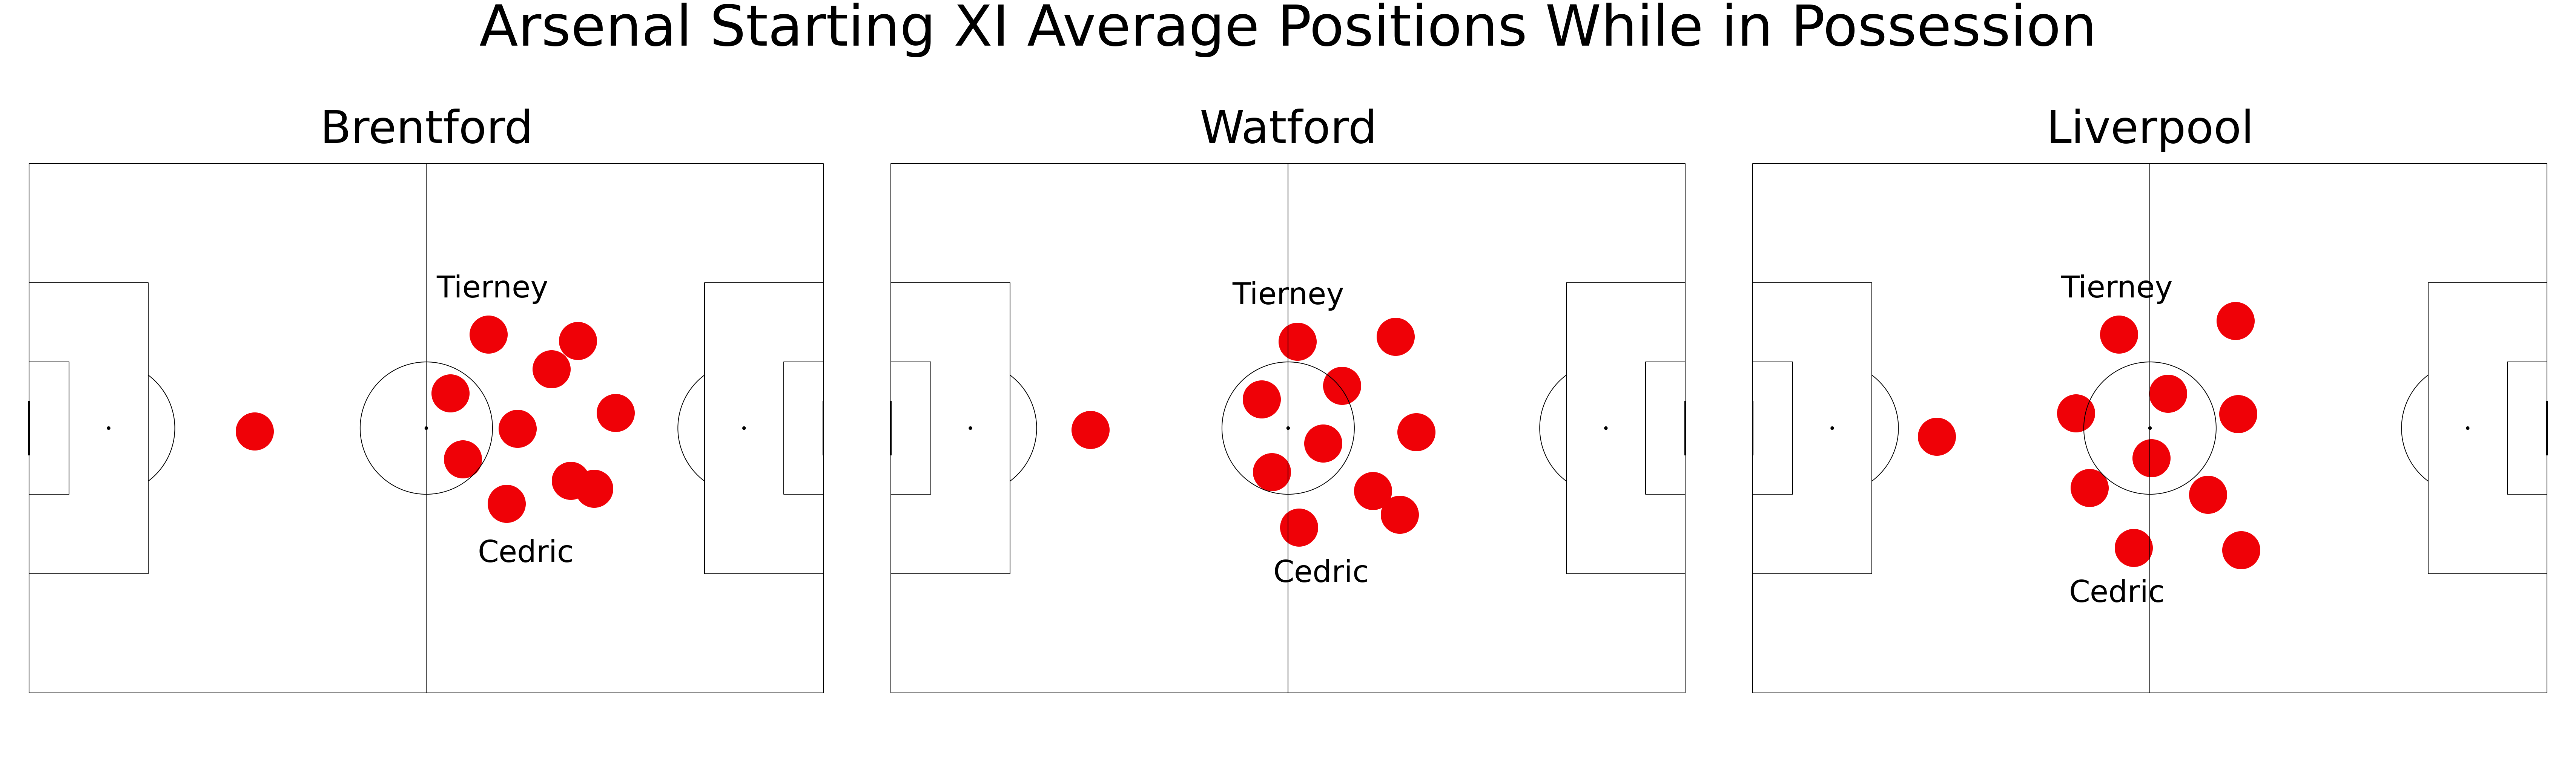

In [31]:
# Average position pitch maps 
pitch = Pitch(line_zorder=2, line_color='black')

fig, axs = pitch.grid(nrows=1, ncols=3, figheight=30,axis=False)

for i in range(len(opponent_names)):

    match_positions = startingXI_positions[startingXI_positions['gameId'] == opponent_names[i][0]]
    
    pitch.scatter(match_positions['plotx'], match_positions['ploty'], ax=axs['pitch'][i], s=10000, color=afc_hex)
        
    axs['pitch'][i].text(60, -5, opponent_names[i][1],
            ha='center', va='center', fontsize=120)
    
axs['pitch'][0].text(75, 59, 'Cedric',
        ha='center', va='center', fontsize=80)
axs['pitch'][1].text(65, 62, 'Cedric',
        ha='center', va='center', fontsize=80)
axs['pitch'][2].text(55, 65, 'Cedric',
        ha='center', va='center', fontsize=80)

axs['pitch'][0].text(70, 19, 'Tierney',
        ha='center', va='center', fontsize=80)
axs['pitch'][1].text(60, 20, 'Tierney',
        ha='center', va='center', fontsize=80)
axs['pitch'][2].text(55, 19, 'Tierney',
        ha='center', va='center', fontsize=80)

fig.suptitle("Arsenal Starting XI Average Positions While in Possession", size = 150);

As well as giving the ball away more often on the right hand side, we can see that while we're in possession of the ball, Cedric (Average X Location = 63.8) has tended to be more advanced up the pitch than Tierney (Average X Location = 62), in theory leaving more space in behind for the opposition to exploit, which may be why we see more opposition passes in that area in transition.

There may also be an element of the opposition deliberately funnelling more attacks down our right hand side to exploit the perceived weakness of Cedric, given that he's been deputising for Tomiyasu whereas Tierney on the left is a starter.

These elements combine to give a picture of more vulnerability when we lose the ball down our right hand side. We were punished for this against Liverpool, whose second goal came after we failed to transition effectively back into defence. When Saka had the ball, Cedric sprinted forward to offer support, and vacated the right back space which Robertson drove into to deliver the assist for Firmino (video below).

In [32]:
# Liverpool 2nd Goal Video 
get_video(77669, 3720000, pre=5, post=10, player=True)

time.sleep(25)
clear_output()

## How well have we performed stopping the opponent progressing the ball after a turnover?

For this, we will look at the same set of sequences as before, namely those that start with the opposition regaining the ball in open play after we lose it

In [33]:
# Opposition sequences aggregation 
opp_sequences = opp_sequences[(~opp_sequences['currPossessionsCnt'].isnull()) &
                              (opp_sequences['teamName'] != 'ARSL')]

opp_sequences['positionX'] = opp_sequences['positionX'] * opp_sequences['attackingDirectionMultiplierX']

opp_sequences_summary = opp_sequences.groupby(
    ['gameId','currentPeriod','currPossessionsCnt'],
    as_index = False
).agg({'gameState':'min',
       'sincePeriodStart':['min', 'max'],
       'pass':'sum',
       'success':'mean',
       'expectedGoalValue':['first','last','max'],
       'positionX':['first','last','max']})

opp_sequences_summary.columns = ['gameId','currentPeriod', 'currPossessionsCnt','gameState',
                                 'startTime', 'endTime', 'passes', 'passSuccess','first_xG',
                                 'last_xG','max_xG', 'firstX', 'lastX', 'maxX']

In [34]:
# Opposition sequences derived metrics 
opp_sequences_summary['seconds'] = (opp_sequences_summary['endTime'] - opp_sequences_summary['startTime'])/1000
opp_sequences_summary['last_xGChange'] = opp_sequences_summary['last_xG'] - opp_sequences_summary['first_xG']
opp_sequences_summary['max_xGChange'] = opp_sequences_summary['max_xG'] - opp_sequences_summary['first_xG']
opp_sequences_summary['lastXChange'] = opp_sequences_summary['lastX'] - opp_sequences_summary['firstX']
opp_sequences_summary['maxXChange'] = opp_sequences_summary['maxX'] - opp_sequences_summary['firstX']

### Sequence Length

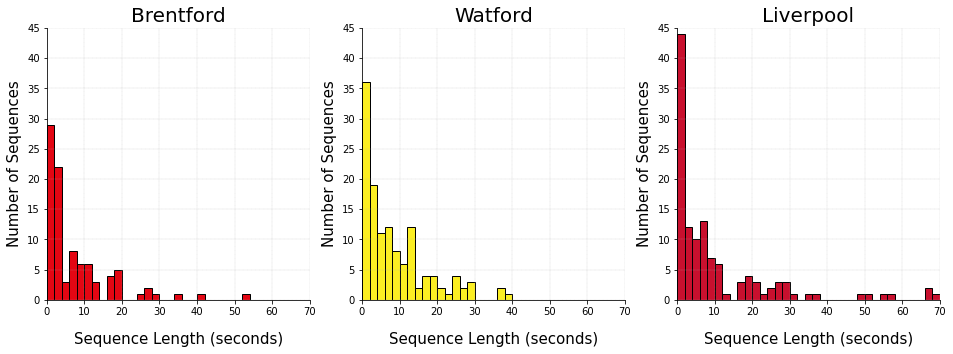

In [35]:
# Sequence length (seconds) histograms 
fig, axs = plt.subplots(1, 3, figsize=(16,5))

for i in range(len(opponent_names)):
    
    match_sequences = opp_sequences_summary[opp_sequences_summary['gameId'] == opponent_names[i][0]]
    
    match_sequences['seconds'].hist(ax=axs[i],
                                    color=opponent_names[i][2],
                                    bins=np.arange(0,72,2),
                                    edgecolor='black')
    axs[i].set_xlabel('Sequence Length (seconds)', size=15, labelpad=15)
    axs[i].set_ylabel('Number of Sequences', size=15, labelpad=5)
    axs[i].set_xlim(0,70)
    axs[i].set_ylim(0,45)
    axs[i].set_title(opponent_names[i][1], size=20)
    axs[i].grid(linestyle='--', linewidth=0.25)
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)

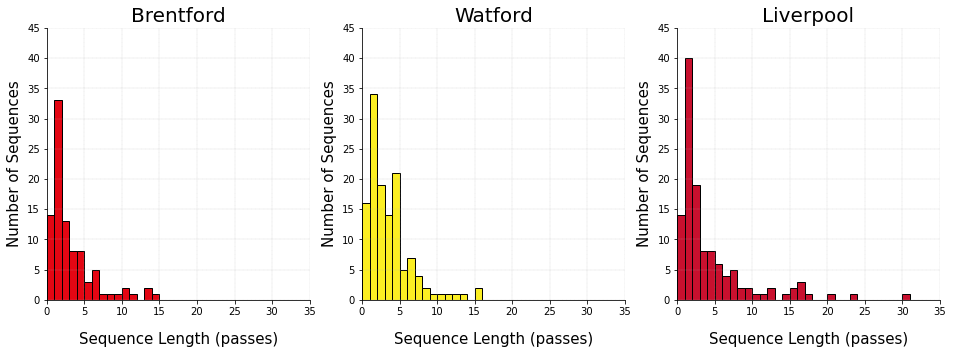

In [36]:
# Sequence length (passes) histograms 
fig, axs = plt.subplots(1, 3, figsize=(16,5))

for i in range(len(opponent_names)):
    
    match_sequences = opp_sequences_summary[opp_sequences_summary['gameId'] == opponent_names[i][0]]
    
    match_sequences['passes'].hist(ax=axs[i],
                                   color=opponent_names[i][2],
                                    bins=np.arange(0,32,1),
                                    edgecolor='black')
    axs[i].set_xlabel('Sequence Length (passes)', size=15, labelpad=15)
    axs[i].set_ylabel('Number of Sequences', size=15, labelpad=5)
    axs[i].set_xlim(0,35)
    axs[i].set_ylim(0,45)
    axs[i].set_title(opponent_names[i][1], size=20)
    axs[i].grid(linestyle='--', linewidth=0.25)
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)

If we look at the distribution of sequence lengths both in terms of time and number of passes, we can see that the majority of sequences are short. Overall, exactly 50% of these sequences ended within the first 5 seconds, and 78.2% ended within the first 5 passes.

However, the long tail of the distribution shows that sequences when the opposition were able to keep hold of the ball past the first 5 seconds, they were able to keep hold of it for more significant periods of time and we struggled to win it back. 59.9% of sequences that were longer than 5 seconds were also longer than 10 seconds, and 25.6% were longer than 20 seconds.

Against Liverpool, we hit exactly the 50% mark of sequences ended within the first 5 seconds, but allowed 36.1% to continue longer than 20 seconds. Against Brentford on the other hand, 55.9% of sequences ended within the first 5 seconds. This will be partly a reflection of opposition style (e.g. we would expect Liverpool to have longer sequences than Brenftord in general) and partly a reflection of the effectiveness of our defensive transitions.

### Change in Expected Goals 

In [37]:
# xG progression calculations 
xg_change_summary = opp_sequences_summary.groupby(
    'gameId', as_index=False
)[['first_xG','max_xG','max_xGChange']].mean()

xg_change_summary['opponent'] = pd.Series(['Brentford', 'Watford', 'Liverpool'])

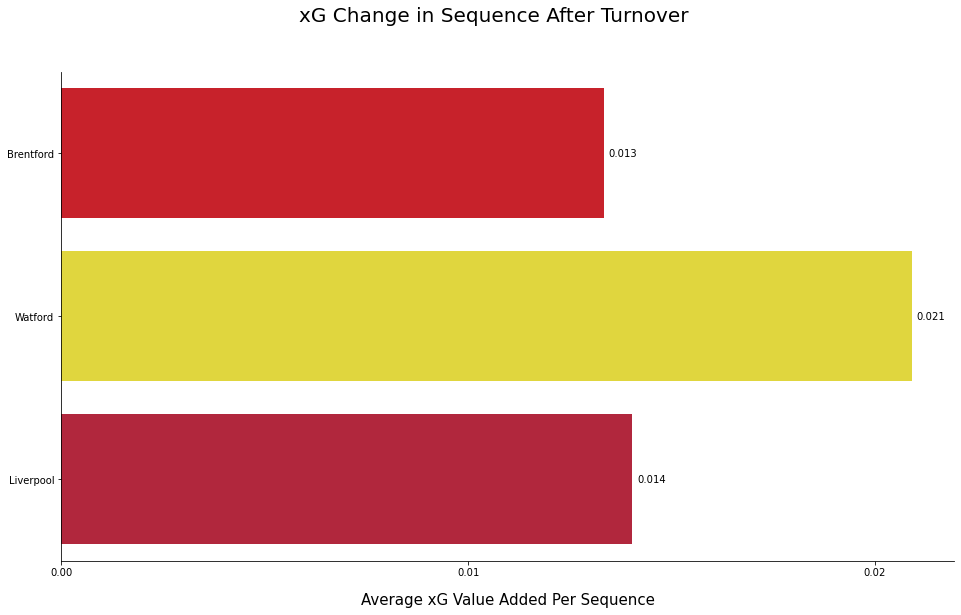

In [38]:
# xG progression plot 
fig = plt.figure(figsize=(16,9))

ax = sns.barplot(y = xg_change_summary['opponent'],
            x = xg_change_summary['max_xGChange'],
            palette=[bfc_hex, wfc_hex, lfc_hex])

ax.set_xlabel('Average xG Value Added Per Sequence', size=15, labelpad = 15)
ax.set_xticks([0, 0.01, 0.02])
ax.set_ylabel('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.bar_label(ax.containers[0], fmt='%.3f', padding =5)

fig.suptitle("xG Change in Sequence After Turnover", size=20);

If we look at the difference between the xG Value at the start of the opposition's sequence and the maximum xG Value they achieved during that sequence, we can get a sense of how much we allowed them to move the ball into dangerous positions after we lost possession.

The peformance against Watford stands out here - as we saw earlier, it's not that we were losing the ball in more dangerous positions against Watford than Liverpool; instead, we allowed them to move into more dangerous positions too easily after losing the ball.

Indeed, the 3 biggest changes between maximum xG and starting xG were against Watford, and the videos are all included below.

In the first two examples here, we were slow to put pressure on the opposition and instead sat back in a deeper block. In the third example, Saka made an attempt to put pressure on Sissoko after the ball is lost, but Martinelli, who was the closest to the ball, sat off and allowed Watford to switch the ball to our left flank and progress the ball there. This highlights the importance of putting pressure on the ball immediately after a turnover to prevent the opponent from progressing the ball and creating higher value chances.

In [39]:
# Dennis Shot Video: 0.43 xG 
get_video(77512, 4377000, pre=5, post=35, player=True)

time.sleep(50)
clear_output()

In [40]:
# Sissoko Goal Video: 0.33 xG 
get_video(77512, 5322000, pre=25, post=30, player=True)

time.sleep(40)
clear_output()

In [41]:
# Dennis Shot Video: 0.25 xG 
get_video(77512, 3850000, pre=5, post=30, player=True)

time.sleep(45)
clear_output()

### Ball Progression

In [42]:
# Average ball progression calculations 
X_change_summary = opp_sequences_summary.groupby(
    'gameId', as_index=False
)[['firstX','maxX','maxXChange']].mean()

X_change_summary['opponent'] = pd.Series(['Brentford', 'Watford', 'Liverpool'])

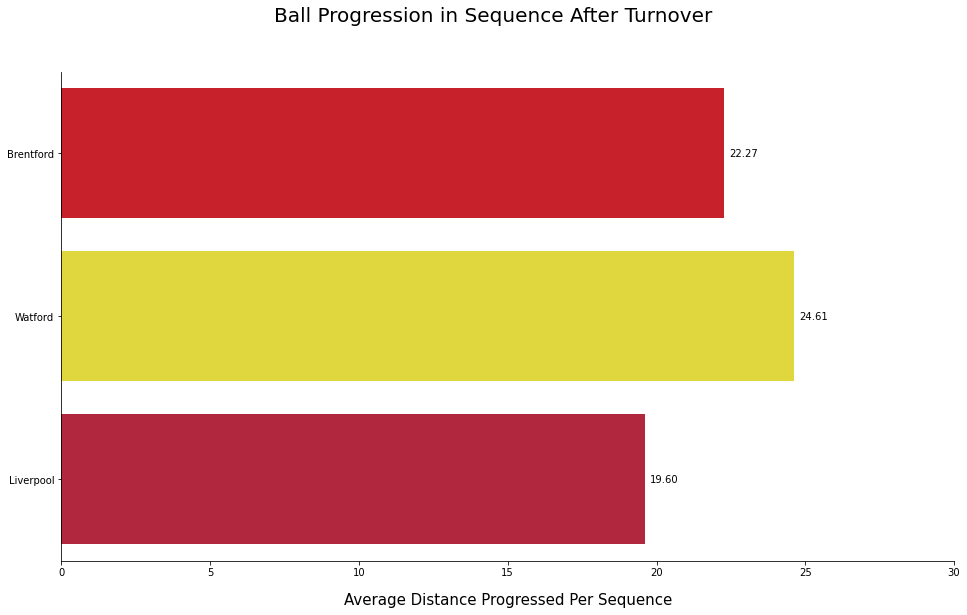

In [43]:
# Ball progression plot 
fig = plt.figure(figsize=(16,9))

ax = sns.barplot(y = X_change_summary['opponent'],
            x = X_change_summary['maxXChange'],
            palette=[bfc_hex, wfc_hex, lfc_hex])

ax.set_xlabel('Average Distance Progressed Per Sequence', size=15, labelpad = 15)
ax.set_xlim(0,30)
ax.set_ylabel('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.bar_label(ax.containers[0], fmt='%.2f', padding =5)

fig.suptitle("Ball Progression in Sequence After Turnover", size=20);

It's a similar story when we look purely at the difference between how far up the pitch the opposition were when they got the ball back, and how far they got during the sequence. Against Watford, we struggled to stop them progressing the ball after we lost it, but we performed better in this regard against Liverpool.

## How compact have we been as a team in transition?

In [44]:
# Team centre of mass calculations 
tracking = tracking.merge(playerTeams)
tracking['GK'] = tracking['playerId'].apply(lambda x: 1 if x in [49835, 49875, 93013, 67618] else 0)

team_centre_of_mass = tracking[tracking['GK'] == 0].groupby(
    ['gameId', 'currentPeriod','sincePeriodStart', 'teamId'], as_index=False
)[['fieldcoordinatex', 'fieldcoordinatey']].mean()

team_centre_of_mass = team_centre_of_mass.rename(
    columns={'fieldcoordinatex':'teamCentreX', 'fieldcoordinatey':'teamCentreY'})

In [45]:
# Team compactness calculations 
tracking = tracking.merge(team_centre_of_mass,
                          on=['gameId','currentPeriod','sincePeriodStart','teamId'],
                          how='left')

tracking['distanceFromCentre'] = np.sqrt((tracking['teamCentreX']-tracking['fieldcoordinatex'])**2 + \
                                            (tracking['teamCentreY']-tracking['fieldcoordinatey'])**2)

tracking['distanceX'] = abs(tracking['teamCentreX'] - tracking['fieldcoordinatex'])
tracking['distanceY'] = abs(tracking['teamCentreY'] - tracking['fieldcoordinatey'])

team_compactness = tracking[tracking['GK'] == 0].groupby(
    ['gameId', 'currentPeriod', 'sincePeriodStart', 'teamId'], as_index = False
)[['distanceFromCentre', 'distanceX', 'distanceY']].mean()

In order to calculate quantify compactness, I've used the average location of the team's outfield players to identify the centre of the team. I then calculated the distance from the centre of each of the outfield players and took an average of those distances to represent the team's compactness. If we look just at the difference of their X coordinates, we can get a measure of vertical compactness, and similarly with Y coordinates to get a measure of horizontal compactness.

Here, a bigger number means that the average distances between players is bigger, and therefore the team is less compact.

The plots below contain some examples of this metric:

In [46]:
# Finding examples 
spread_examples = tracking[((tracking['gameId'] == 77214) & (tracking['teamId'] == 234) &
                  (tracking['sincePeriodStart'] == 374560) & (tracking['currentPeriod'] == 1)) |
                         ((tracking['gameId'] == 77669) & (tracking['teamId'] == 234) &
                  (tracking['sincePeriodStart'] == 305840) & (tracking['currentPeriod'] == 1))]

spread_examples['plotx'] = spread_examples['fieldcoordinatex'] * \
                                    spread_examples['attackingDirectionMultiplier'] + 60
# Applying this conversion to fit the plot
spread_examples['ploty'] = 80 - (spread_examples['fieldcoordinatey'] * \
                                    spread_examples['attackingDirectionMultiplier'] + 45) * (80/90)

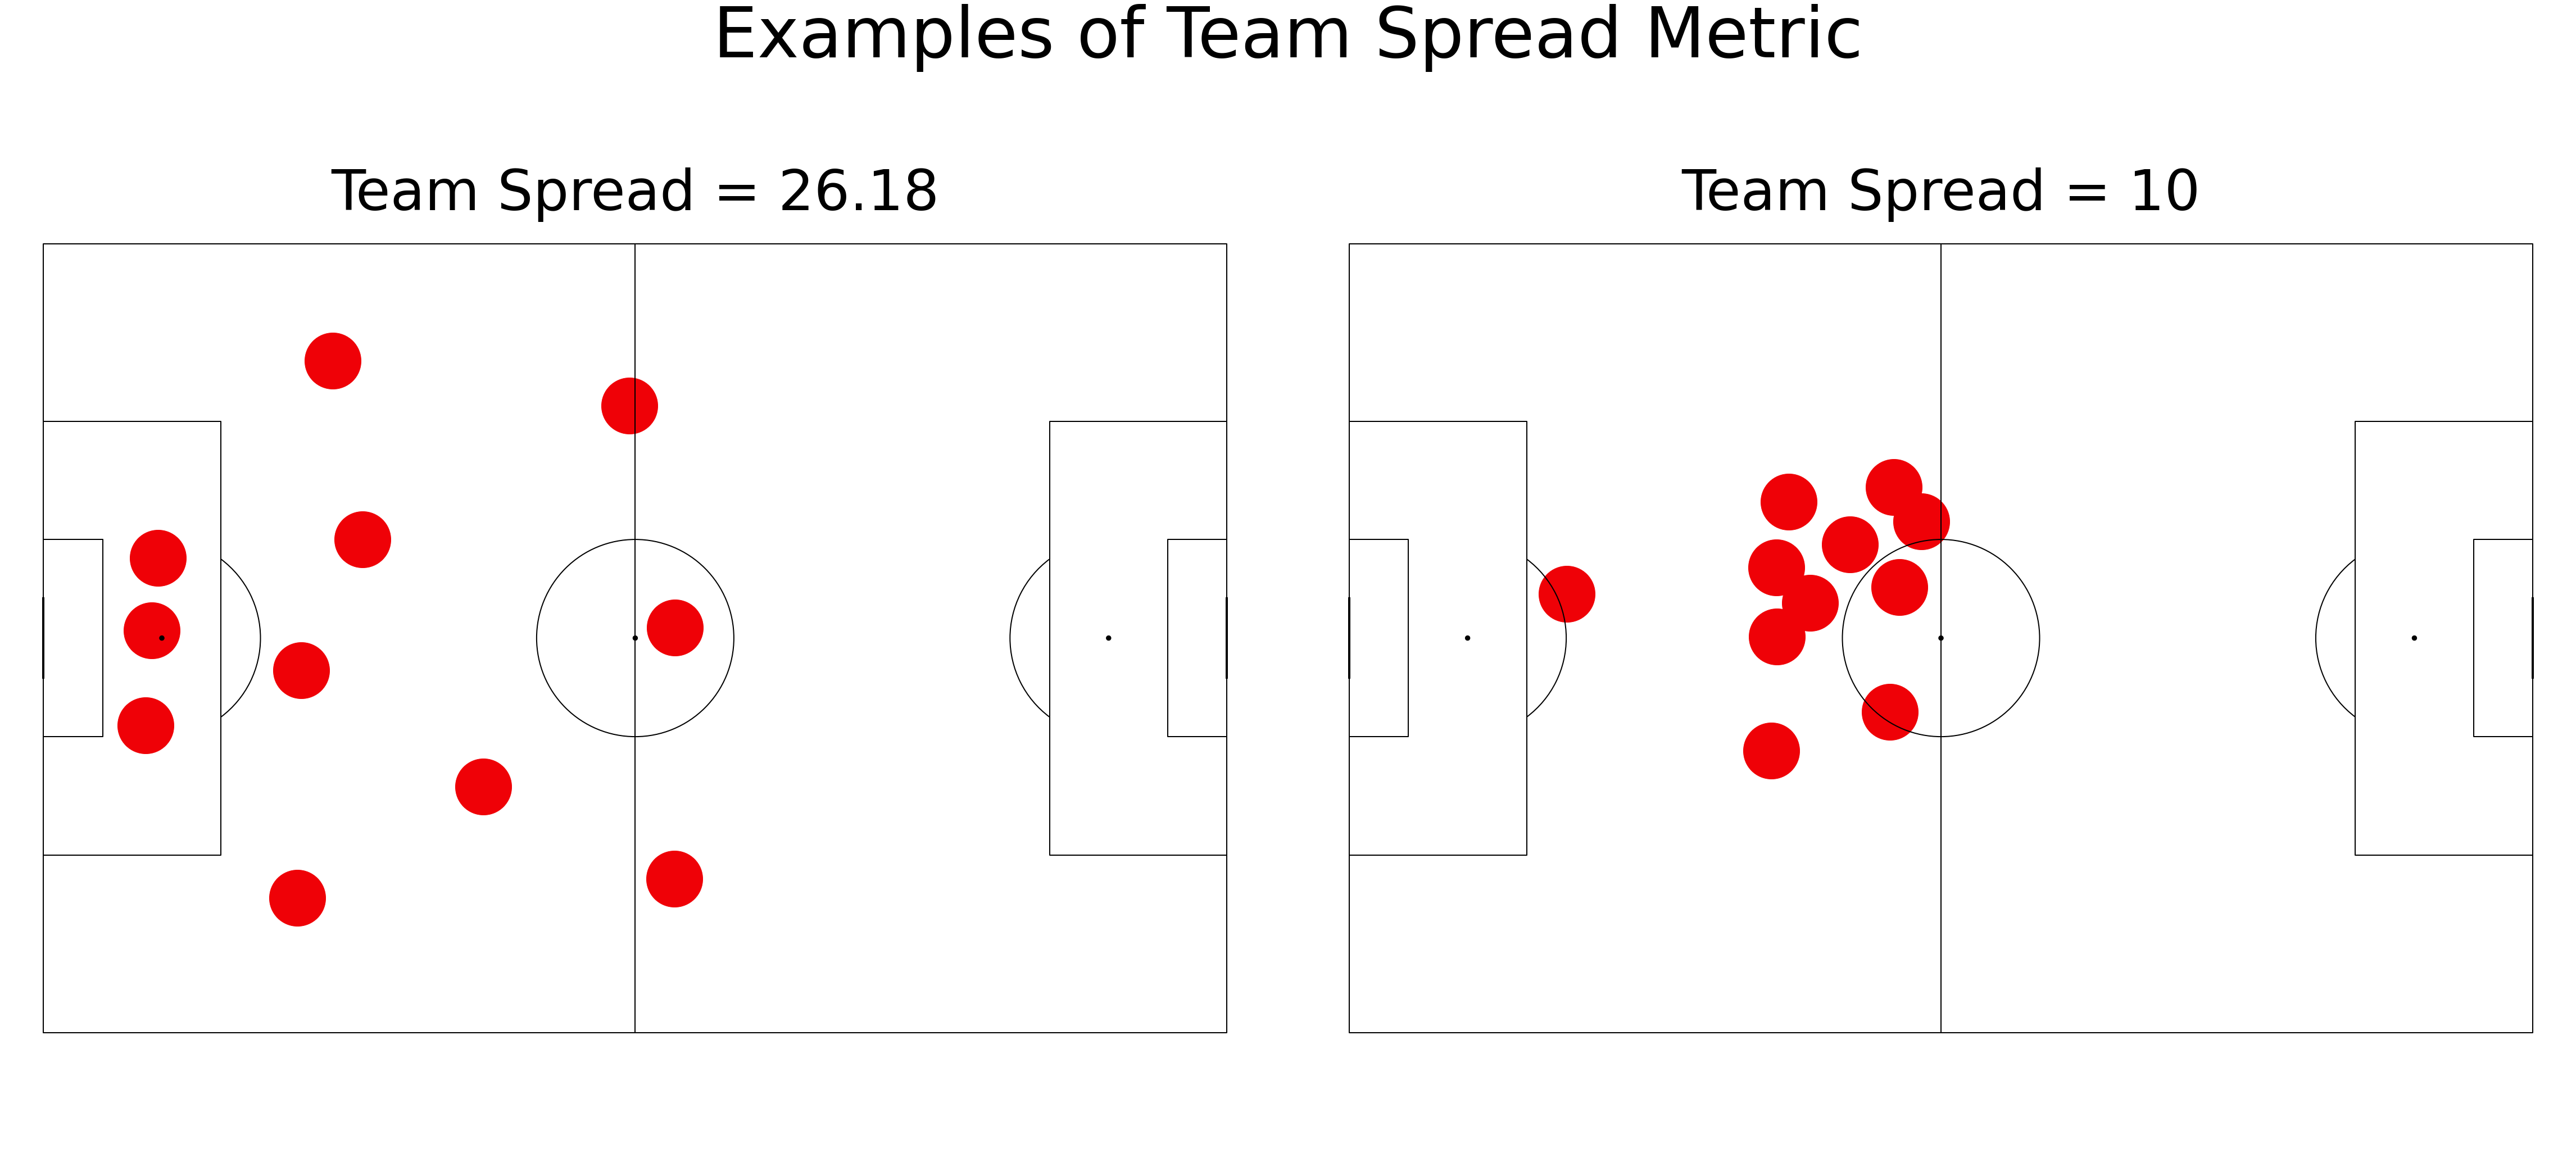

In [47]:
# Team spread pitch maps 
pitch = Pitch(line_zorder=2, line_color='black')

fig, axs = pitch.grid(nrows=1, ncols=2, figheight=30,axis=False)

pitch.scatter(spread_examples[spread_examples['gameId'] == 77214]['plotx'], 
              spread_examples[spread_examples['gameId'] == 77214]['ploty'],
              ax=axs['pitch'][0], s=10000, color=afc_hex)

axs['pitch'][0].text(60, -5, "Team Spread = 26.18",
        ha='center', va='center', fontsize=100)

pitch.scatter(spread_examples[spread_examples['gameId'] == 77669]['plotx'], 
              spread_examples[spread_examples['gameId'] == 77669]['ploty'],
              ax=axs['pitch'][1], s=10000, color=afc_hex)

axs['pitch'][1].text(60, -5, "Team Spread = 10",
        ha='center', va='center', fontsize=100)

fig.suptitle("Examples of Team Spread Metric", fontsize=125);

On the left here, you can see an example of our team shape against Brentford following a goal kick. The team is spread out across most of our own half, and so we have a high *Team Spread* value of **26.18**.

On the right, against Liverpool, the team is very compact, with all the outfielders squeezed into a short, narrow rectangle. This gives a *Team Spread* value of **10**.

### Compactness in Possession

In [48]:
# Compactness at loss of possession calculations 
end_of_possession = events_selected[events_selected['inPlayEnd'] == 1]

end_of_possession_compactness = pd.merge_asof(
    end_of_possession[['gameId', 'currentPeriod', 'sincePeriodStart','gameState','possessionTeamIdUninterrupted']].sort_values(
        'sincePeriodStart'),
    team_compactness.sort_values('sincePeriodStart'), 
    on = 'sincePeriodStart',
    by = ['gameId', 'currentPeriod']
)

possession_compactness_summary = end_of_possession_compactness.groupby(
    ['gameId', 'teamId'], as_index = False
)[['distanceFromCentre', 'distanceX', 'distanceY']].mean()

possession_compactness_summary['label'] = pd.Series(['AFC (vs BFC)', 'Brentford',
                                                     'AFC (vs WFC)', 'Watford',
                                                     'AFC (vs LFC)', 'Liverpool'])

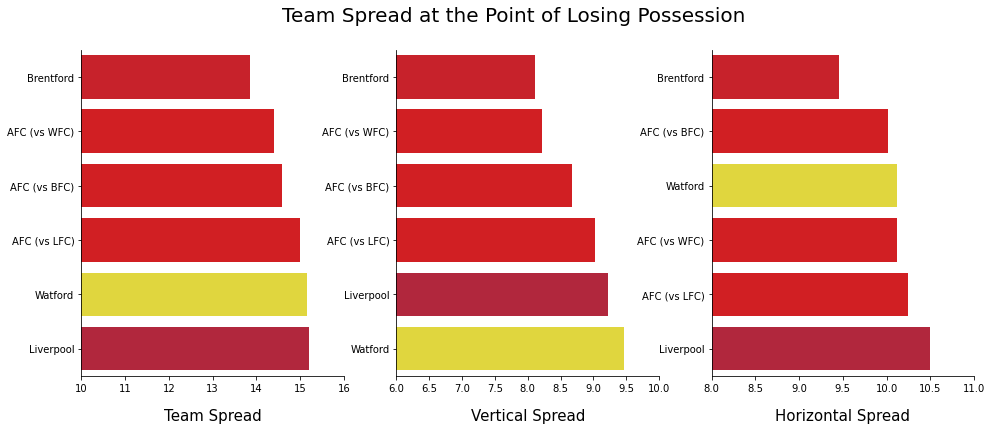

In [49]:
# Team spread at loss of possession plot 
fig, axs = plt.subplots(1, 3, figsize=(16,6))

sns.barplot(x=possession_compactness_summary['distanceFromCentre'],
            y=possession_compactness_summary['label'], ax=axs[0],
            palette=[bfc_hex, afc_hex, afc_hex, afc_hex, wfc_hex, lfc_hex],
            order=possession_compactness_summary.sort_values('distanceFromCentre')['label'])

axs[0].set_xlabel("Team Spread", size=15, labelpad=15)
axs[0].set_ylabel("")
axs[0].set_xlim(10, 16)
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)

sns.barplot(x=possession_compactness_summary['distanceX'],
            y=possession_compactness_summary['label'], ax=axs[1],
            palette=[bfc_hex, afc_hex, afc_hex, afc_hex, lfc_hex, wfc_hex],
            order=possession_compactness_summary.sort_values('distanceX')['label'])

axs[1].set_xlabel("Vertical Spread", size=15, labelpad=15)
axs[1].set_ylabel("")
axs[1].set_xlim(6, 10)
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)

sns.barplot(x=possession_compactness_summary['distanceY'],
            y=possession_compactness_summary['label'], ax=axs[2],
            palette=[bfc_hex, afc_hex, wfc_hex, afc_hex, afc_hex, lfc_hex],
            order=possession_compactness_summary.sort_values('distanceY')['label'])

axs[2].set_xlabel("Horizontal Spread", size=15, labelpad=15)
axs[2].set_ylabel("")
axs[2].set_xlim(8, 11)
axs[2].spines['top'].set_visible(False)
axs[2].spines['right'].set_visible(False)

fig.suptitle("Team Spread at the Point of Losing Possession", size=20);

These charts show teams' compactness at the time of the event which loses possession, whether this is a shot, a pass or a clearance. This gives a benchmark to measure the effectiveness of the transition into defence, since it is obviously harder to be compact if you're starting from a more spread out position.

Against Liverpool, we were noticeably less compact at the point of losing possession than against Brentford and Watford, especially in the vertical direction. The values for our opposition are also provided for comparison.

### Compactness during Transition

In [50]:
def add_opposition_id(df):
    
    """This function adds the out of possession team's teamId"""
    
    if df['possessionTeamIdUninterrupted'] != 234:
        df['oppositionId'] = float(234)
    elif df['gameId'] == 77214:
        df['oppositionId'] = float(1226)
    elif df['gameId'] == 77512:
        df['oppositionId'] = float(771)
    elif df['gameId'] == 77669:
        df['oppositionId'] = float(235)
        
    return df

In [51]:
# Identifying defensive transition events 
transition_events_all = events_selected[(events_selected['arsenalPhase'] == 'TransitionAttackToDefence') |
                (events_selected['oppositionPhase'] == 'TransitionAttackToDefence')]

transition_events_all = transition_events_all.apply(add_opposition_id, axis=1)

In [52]:
# Compactness in transition calculations 
transition_compactness = pd.merge_asof(
    transition_events_all[['gameId', 'currentPeriod', 'sincePeriodStart','gameState','oppositionId']].sort_values(
        'sincePeriodStart'),
    team_compactness.sort_values('sincePeriodStart'), 
    on = 'sincePeriodStart',
    left_by = ['gameId', 'currentPeriod', 'oppositionId'],
    right_by = ['gameId', 'currentPeriod', 'teamId'],
)

transition_compactness_summary = transition_compactness.groupby(
    ['gameId', 'teamId'], as_index = False
)[['distanceFromCentre', 'distanceX', 'distanceY']].mean()

transition_compactness_summary['label'] = pd.Series(['AFC (vs BFC)', 'Brentford',
                                                     'AFC (vs WFC)', 'Watford',
                                                     'AFC (vs LFC)', 'Liverpool'])

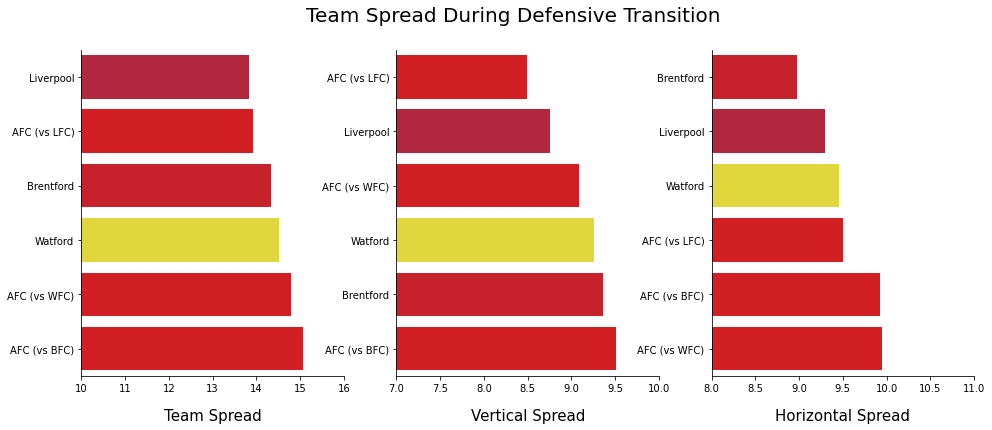

In [53]:
# Team spread during transition plot 
fig, axs = plt.subplots(1, 3, figsize=(16,6))

sns.barplot(x=transition_compactness_summary['distanceFromCentre'],
            y=transition_compactness_summary['label'], ax=axs[0],
            palette=[lfc_hex, afc_hex, bfc_hex, wfc_hex, afc_hex, afc_hex],
            order=transition_compactness_summary.sort_values('distanceFromCentre')['label'])

axs[0].set_xlabel("Team Spread", size=15, labelpad=15)
axs[0].set_ylabel("")
axs[0].set_xlim(10, 16)
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)

sns.barplot(x=transition_compactness_summary['distanceX'],
            y=transition_compactness_summary['label'], ax=axs[1],
            palette=[afc_hex, lfc_hex, afc_hex, wfc_hex, bfc_hex, afc_hex],
            order=transition_compactness_summary.sort_values('distanceX')['label'])

axs[1].set_xlabel("Vertical Spread", size=15, labelpad=15)
axs[1].set_ylabel("")
axs[1].set_xlim(7, 10)
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)

sns.barplot(x=transition_compactness_summary['distanceY'],
            y=transition_compactness_summary['label'], ax=axs[2],
            palette=[bfc_hex, lfc_hex, wfc_hex, afc_hex, afc_hex, afc_hex],
            order=transition_compactness_summary.sort_values('distanceY')['label'])

axs[2].set_xlabel("Horizontal Spread", size=15, labelpad=15)
axs[2].set_ylabel("")
axs[2].set_xlim(8, 11)
axs[2].spines['top'].set_visible(False)
axs[2].spines['right'].set_visible(False)

fig.suptitle("Team Spread During Defensive Transition", size=20);

It stands out how Liverpool have gone from the most spread out team at the point of losing the ball to the most compact during defensive transition. Their effectiveness in transition is a key part of their *gegenpressing* style, and one aspect of that style seems to be their ability to become compact quickly after losing the ball.

For Arsenal, our lack of horizontal compactness (i.e. our shape not being narrow enough) is noticeable, particularly against Brentford and Watford. Brentford was also our least vertically compact game.

But given our effectiveness in quickly disrupting Brentford's sequences after we lost the ball and minimising their ball progression, this does not necessarily mean we were doing the wrong thing.

### Compactness after 5 seconds

In [54]:
# Compactness after 5 seconds calculations 
five_secs = opp_sequences_summary[opp_sequences_summary['seconds'] > 5]

five_secs_compactness = pd.merge_asof(
    five_secs[['gameId', 'currentPeriod', 'startTime']].sort_values(
        'startTime'),
    team_compactness[team_compactness['teamId'] == 234].sort_values('sincePeriodStart'), 
    left_on = 'startTime',
    right_on = 'sincePeriodStart',
    left_by = ['gameId', 'currentPeriod'],
    right_by = ['gameId', 'currentPeriod'],
)

five_secs_compactness['fiveSecsLater'] = five_secs_compactness['sincePeriodStart'] + 5000

five_secs_compactness = five_secs_compactness.merge(
    team_compactness,
    left_on = ['gameId', 'currentPeriod','teamId','fiveSecsLater'],
    right_on = ['gameId', 'currentPeriod','teamId','sincePeriodStart'],
    suffixes = ("", "PlusFive")
)

five_secs_compactness['compactnessChange'] = five_secs_compactness['distanceFromCentre'] -\
                                                five_secs_compactness['distanceFromCentrePlusFive']

five_secs_compactness['verticalChange'] = five_secs_compactness['distanceX'] -\
                                                five_secs_compactness['distanceXPlusFive']

five_secs_compactness['horizontalChange'] = five_secs_compactness['distanceY'] -\
                                                five_secs_compactness['distanceYPlusFive']

five_secs_compactness_summary = five_secs_compactness.groupby(
    'gameId', as_index = False
)[['compactnessChange', 'verticalChange', 'horizontalChange']].mean()

five_secs_compactness_summary['opponent'] = pd.Series(['Brentford', 'Watford', 'Liverpool'])

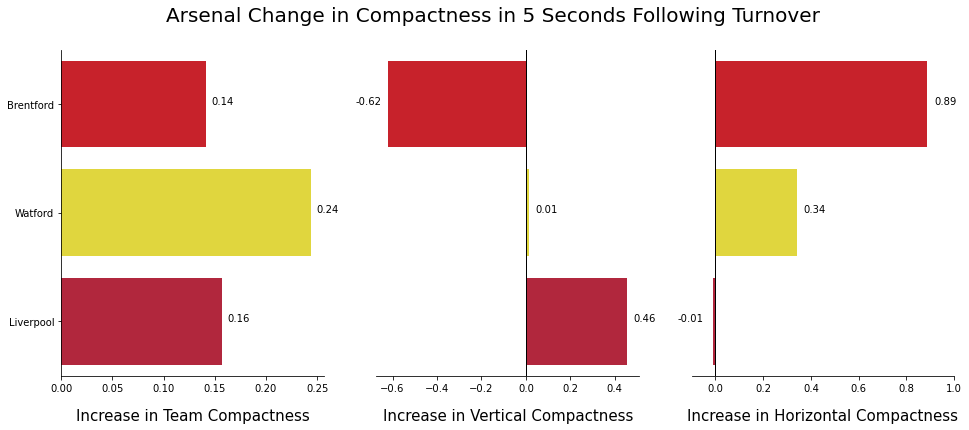

In [55]:
# Change in compactness plot 
fig, axs = plt.subplots(1, 3, figsize=(16,6))

sns.barplot(x=five_secs_compactness_summary['compactnessChange'],
            y=five_secs_compactness_summary['opponent'], ax=axs[0],
            palette=[bfc_hex, wfc_hex, lfc_hex])

axs[0].set_xlabel("Increase in Team Compactness", size=15, labelpad=15)
axs[0].set_ylabel("")
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)

for i in range(len(five_secs_compactness_summary['opponent'])):
    axs[0].text(five_secs_compactness_summary['compactnessChange'][i] + 0.005,
            i,
            round(five_secs_compactness_summary['compactnessChange'][i],2));

sns.barplot(x=five_secs_compactness_summary['verticalChange'],
            y=five_secs_compactness_summary['opponent'], ax=axs[1],
            palette=[bfc_hex, wfc_hex, lfc_hex])

axs[1].set_xlabel("Increase in Vertical Compactness", size=15, labelpad=15)
axs[1].set_ylabel("")
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].spines['left'].set_visible(False)
axs[1].set_yticks([])
axs[1].axvline(0, color='black', linewidth=1)

for i in range(len(five_secs_compactness_summary['opponent'])):
    if five_secs_compactness_summary['verticalChange'][i] < 0:
        axs[1].text(five_secs_compactness_summary['verticalChange'][i] - 0.15,
                i,
                round(five_secs_compactness_summary['verticalChange'][i],2))
    else:
        axs[1].text(five_secs_compactness_summary['verticalChange'][i] + 0.03,
                i,
                round(five_secs_compactness_summary['verticalChange'][i],2));

sns.barplot(x=five_secs_compactness_summary['horizontalChange'],
            y=five_secs_compactness_summary['opponent'], ax=axs[2],
            palette=[bfc_hex, wfc_hex, lfc_hex])

axs[2].set_xlabel("Increase in Horizontal Compactness", size=15, labelpad=15)
axs[2].set_ylabel("")
axs[2].set_xlim(-0.1, 1)
axs[2].spines['top'].set_visible(False)
axs[2].spines['right'].set_visible(False)
axs[2].spines['left'].set_visible(False)
axs[2].set_yticks([])
axs[2].axvline(0, color='black', linewidth=1)

for i in range(len(five_secs_compactness_summary['opponent'])):
    if five_secs_compactness_summary['horizontalChange'][i] < 0:
        axs[2].text(five_secs_compactness_summary['horizontalChange'][i] - 0.15,
                i,
                round(five_secs_compactness_summary['horizontalChange'][i],2))
    else:
        axs[2].text(five_secs_compactness_summary['horizontalChange'][i] + 0.03,
                i,
                round(five_secs_compactness_summary['horizontalChange'][i],2));

fig.suptitle("Arsenal Change in Compactness in 5 Seconds Following Turnover", size=20);

Against all three opponents, we became more compact overall 5 seconds after losing the ball, but in different ways. Against Brentford, we became significantly narrower, but more spread vertically, whereas against Liverpool we became significantly more vertically compact, but no major difference horizontally. Against Watford, there was no major difference vertically, but we did become more narrow.

## What are the factors that might impact our performance in defensive transition?

### Game State

#### Sequence Length

In [56]:
# Sequence length by game state calculations 
game_state_length = opp_sequences_summary.groupby(
    'gameState', as_index = False
)[['seconds', 'passes']].mean()

game_state_length['label'] = pd.Series(['Losing', 'Drawing', 'Winning'])

game_state_length = game_state_length.rename(
    columns={'seconds':'Sequence Length (seconds)','passes':'Sequence Length (passes)'})

game_state_length = game_state_length.melt(
    id_vars=['gameState', 'label'],
    value_vars=['Sequence Length (seconds)', 'Sequence Length (passes)'])

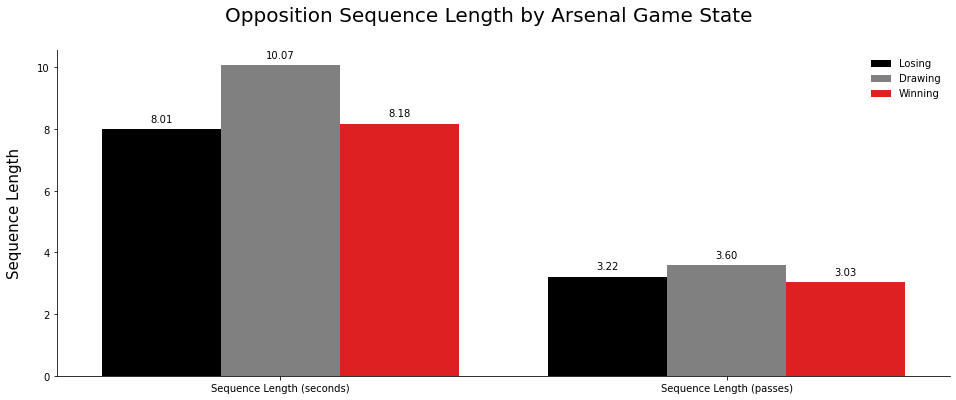

In [57]:
# Sequence length by game state plot 
fig = plt.figure(figsize = (16,6))

ax = sns.barplot(x=game_state_length['variable'],
                y=game_state_length['value'],
                hue=game_state_length['label'],
                palette = ['black', 'grey', 'red'])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('')
ax.set_ylabel("Sequence Length", size=15, labelpad=15)
ax.legend(frameon = False)

for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding =5)
    
fig.suptitle("Opposition Sequence Length by Arsenal Game State", size=20);

#### Change in Expected Goals

In [58]:
# xG change by game state calculations 
game_state_xg = opp_sequences_summary.groupby(
    'gameState', as_index=False
)[['first_xG','max_xG','max_xGChange']].mean()
game_state_xg['label'] = pd.Series(['Losing', 'Drawing', 'Winning'])

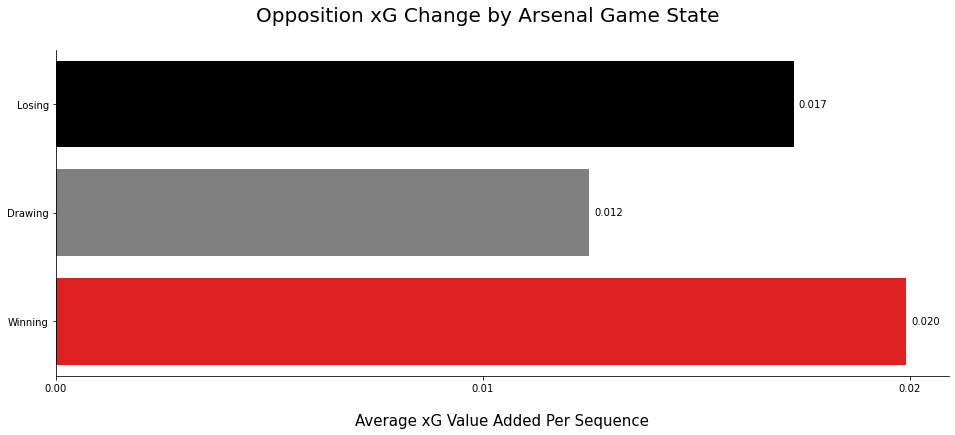

In [59]:
# xG change by game state plot 
fig = plt.figure(figsize = (16,6))

ax = sns.barplot(x=game_state_xg['max_xGChange'],
                y=game_state_xg['label'],
                palette = ['black', 'grey', 'red'])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('')
ax.set_xlabel('Average xG Value Added Per Sequence', size=15, labelpad = 20)
ax.set_xticks([0, 0.01, 0.02])

ax.bar_label(ax.containers[0], fmt='%.3f', padding =5)

fig.suptitle("Opposition xG Change by Arsenal Game State", size=20);

#### Ball Progression

In [60]:
# Ball progression by game state calculations 
game_state_progression = opp_sequences_summary.groupby(
    'gameState', as_index=False
)[['firstX','maxX','maxXChange']].mean()
game_state_progression['label'] = pd.Series(['Losing', 'Drawing', 'Winning'])

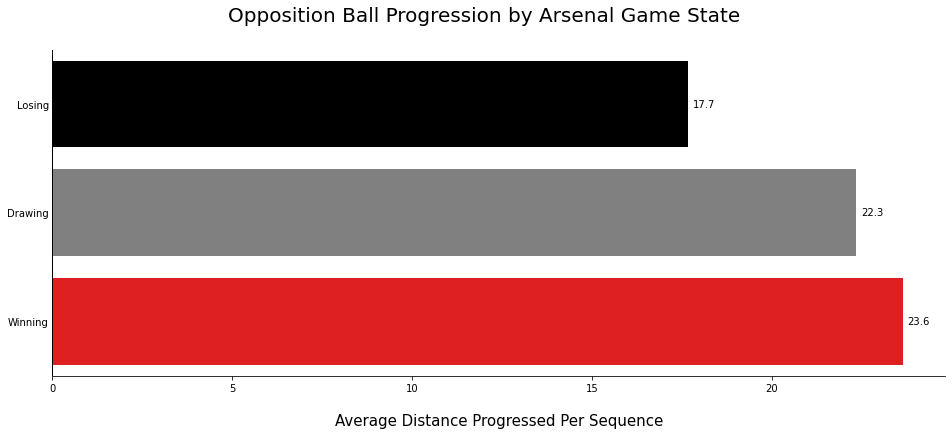

In [61]:
# Ball progression by game state plot 
fig = plt.figure(figsize = (16,6))

ax = sns.barplot(x=game_state_progression['maxXChange'],
                y=game_state_progression['label'],
                palette = ['black', 'grey', 'red'])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_ylabel('')
ax.set_xlabel('Average Distance Progressed Per Sequence', size=15, labelpad = 20)
ax.yaxis.set_tick_params(length=0)
ax.axvline(0, color='black', linewidth=1)

ax.bar_label(ax.containers[0], fmt='%.1f', padding =5)

fig.suptitle("Opposition Ball Progression by Arsenal Game State", size=20);

While more analysis would be needed to confirm if these differences are significant, there are noticeable discrepancies in the way our defensive transition goes depending on the game state:
* When drawing, opposition sequences starting after we lose the ball tend to be longer, both in terms of time and number of passes
* When we're losing, the opposition tend to make the least progress after winning the ball back. This may be a result of improved transitions from us, or may be a result of a more cautious approach from the opposition
    * In these three matches, the only time we were behind was against Liverpool, so it may also be something specific to them and to that match
* While winning, we have actually allowed the opposition to increase xG the most and progress the ball the most following a turnover
    * Again, this may involve a change of approach from the opposition, or may reflect poor defensive transitions from us
    
The most important impact game state would have is on teams' strategy and whether they are more or less prepared to take risks. This is likely to impact performance in transition, but given the small sample (e.g. we were only behind for c. 40 mins against Liverpool), more analysis is required.

### Time

In [62]:
def add_period(df):
    
    """This function splits the game up into six 15 minutes periods and calculates which one
    the match is in."""
    
    if df['currentPeriod'] == 1:
        if df['startTime'] < 900000:
            df['period'] = "0-15"
        elif df['startTime'] < 1800000:
            df['period'] = "15-30"
        else:
            df['period'] = "30-45"
    else:
        if df['startTime'] < 900000:
            df['period'] = "45-60"
        elif df['startTime'] < 1800000:
            df['period'] = "60-75"
        else:
            df['period'] = "75-90"
            
    return df

In [63]:
# Adding time period 
opp_sequences_summary = opp_sequences_summary.apply(add_period, axis=1)

#### Sequence Length

In [64]:
# Sequence length by period calculations 
period_length = opp_sequences_summary.groupby(
    'period', as_index = False
)[['seconds', 'passes']].mean()

period_length = period_length.rename(
    columns={'seconds':'Sequence Length (s)','passes':'Sequence Length (passes)'})

period_length = period_length.melt(
    id_vars=['period'],
    value_vars=['Sequence Length (s)', 'Sequence Length (passes)'])

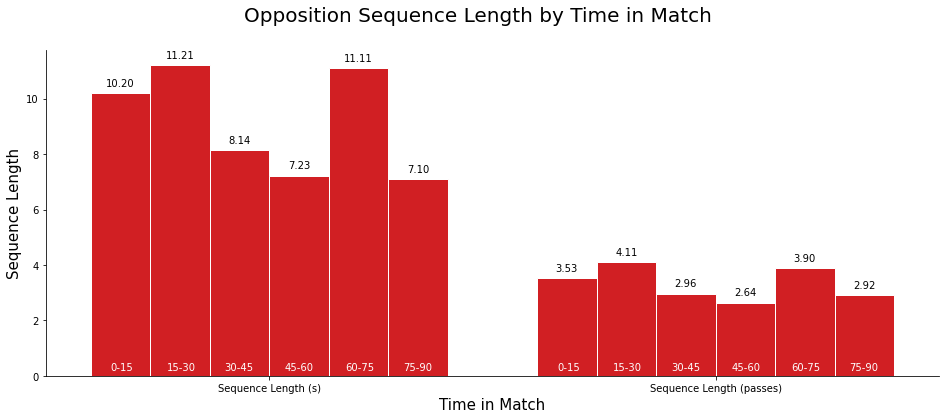

In [65]:
# Sequence length by period plot 
fig = plt.figure(figsize = (16,6))

ax = sns.barplot(x=period_length['variable'],
                y=period_length['value'],
                hue=period_length['period'],
                palette=[afc_hex],
                edgecolor='white')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Time in Match', size=15)
ax.set_ylabel("Sequence Length", size=15)
ax.get_legend().remove()

for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding =5);
    
ax.text(-0.355, 0.2, '0-15', color='white')
ax.text(-0.23, 0.2, '15-30', color='white')
ax.text(-0.10, 0.2, '30-45', color='white')
ax.text(0.035, 0.2, '45-60', color='white')
ax.text(0.17, 0.2, '60-75', color='white')
ax.text(0.30, 0.2, '75-90', color='white')

ax.text(-0.355 + 1, 0.2, '0-15', color='white')
ax.text(-0.23 + 1, 0.2, '15-30', color='white')
ax.text(-0.10 + 1, 0.2, '30-45', color='white')
ax.text(0.035 + 1, 0.2, '45-60', color='white')
ax.text(0.17 + 1, 0.2, '60-75', color='white')
ax.text(0.30 + 1, 0.2, '75-90', color='white')

fig.suptitle("Opposition Sequence Length by Time in Match", size = 20);

#### Change in Expected Goals

In [66]:
# xG change by period calculations 
period_xg = opp_sequences_summary.groupby(
    'period', as_index=False
)[['first_xG','max_xG','max_xGChange']].mean()

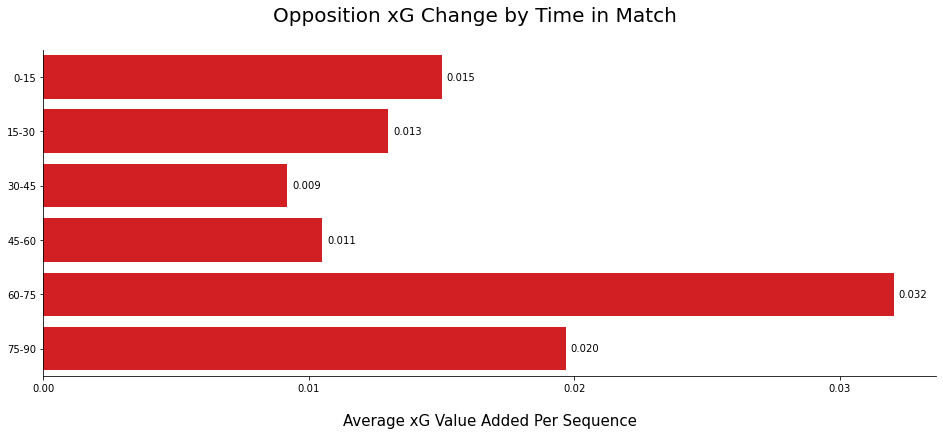

In [67]:
# xG change by period plot 
fig = plt.figure(figsize = (16,6))

ax = sns.barplot(x=period_xg['max_xGChange'],
                y=period_xg['period'],
                palette = [afc_hex])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('')
ax.set_xlabel('Average xG Value Added Per Sequence', size=15, labelpad = 20)
ax.set_xticks([0, 0.01, 0.02, 0.03])

ax.bar_label(ax.containers[0], fmt='%.3f', padding =5)

fig.suptitle("Opposition xG Change by Time in Match", size = 20);

#### Ball Progression

In [68]:
# Ball progression by period calculations 
period_progression = opp_sequences_summary.groupby(
    'period', as_index=False
)[['firstX','maxX','maxXChange']].mean()

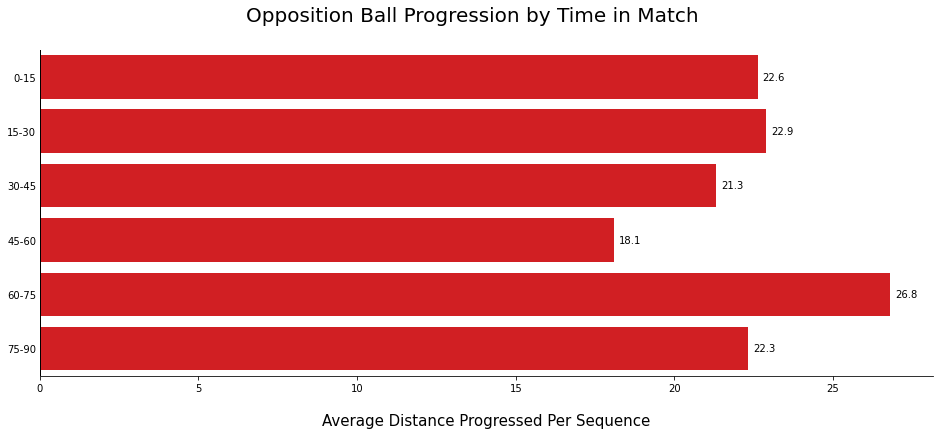

In [69]:
# Ball progression by period plot 
fig = plt.figure(figsize = (16,6))

ax = sns.barplot(x=period_progression['maxXChange'],
                y=period_progression['period'],
                palette = [afc_hex])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_ylabel('')
ax.yaxis.set_tick_params(length=0)
ax.axvline(0, color='black', linewidth=1)
ax.set_xlabel('Average Distance Progressed Per Sequence', size=15, labelpad = 20)

ax.bar_label(ax.containers[0], fmt='%.1f', padding =5)

fig.suptitle("Opposition Ball Progression by Time in Match", size = 20);

We can see from these plots how the success of opposition sequences varies by time in the match:
* We were most effective in transition in the period either side of half time
    * In this period, we allowed the least progression and least xG creation after losing the ball
* As the game opened up towards the end of the match (60-75 mins), we were least effective
    * In this period, the opposition added the most xG and progressed the ball the most
* But this effect tailed off in the final 15 minutes of the match
* The longest sequences came in the period between 15-30 mins 

As teams' levels of fatigue grow throughout the match, it can become harder to counter-press effectively and keep the intensity required for rapid transitions. Also, as time passes in a match, teams' appetite for risk may change, which again can impact performance in transition. Again, more analysis and bigger samples would enable to us to draw more significant conclusions about this.

### Other Factors

Other factors that might impact performance include:
* Where on the pitch the ball is lost
* How the ball is lost
* Locations of all players on the pitch
* Locations of certain key players on the pitch

## What would you like to analyse next?

As well as looking into the other factors that might impact performance listed above, the key area that I would like to analyse is how we can make ourselves more effective in transition from attack to defence while still in possession of the ball. 

For example, there may be certain positional structures that make it much easier for us to win the ball back immediately after we lose it. There have been recent developments in the game, such as *Inverted Full Backs*, who adopt a more central position while their team is in possession so that they are in a better position to prevent counter-attacks. As we saw, the space in behind Cedric on our right hand side seems to be an area that our opposition are targeting, so adopting a more central position rather than overlapping, as Tomiyasu has done at times this season, may enable us to transition more effectively.

Similarly, there may be certain types of passes that make us more vulnerable in transition. For example, it may be that playing short passes means that we always have at least two players (the passer and the receiver) close to the ball if we lose it, which would make it easier to put pressure on the ball immediately. Alternatively, it may be that playing more vertical forward passes means that we always have a player (the passer) between the ball and our goal, which would make it easier to prevent opposition progression. 

Analysing these factors would enable us to understand exactly where we're vulnerable after we lose the ball and how we can best combat that while in possession, so that the transition into defence is easier for us.